**ROSSMANN STORE SALES PREDICTION**

# 0. IMPORTS

## 0.0 Imports

In [2]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb
import random
import inflection
import math
import datetime
import pickle

from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from tabulate              import tabulate
from IPython.display       import Image, display, HTML
from boruta                import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1. Helper Functions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error (y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0])

def mean_percentage_error( y, yhat):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Cweiland\anaconda3\envs\dsproducao\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# Passo 1. DESCRIÇÃO DOS DADOS

## 1.0. Data Copy

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore ( x )

cols_new = list (map ( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance           
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if 
                                                math.isnan( x['competition_open_since_month'] ) else 
                                                x['competition_open_since_month'], axis=1 )
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if 
                                               math.isnan( x['competition_open_since_year'] ) else 
                                               x['competition_open_since_year'], axis=1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if 
                                     math.isnan( x['promo2_since_week'] ) else 
                                     x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if 
                                     math.isnan( x['promo2_since_year'] ) else 
                                     x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if 
                                                             x['promo_interval'] == 0 else 1 
                                                             if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int64 )

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include = ['int64', 'int32', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame (num_attributes.apply ( np.mean ) ).T
ct2 = pd.DataFrame (num_attributes.apply ( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply ( np.std ) ).T
d2 = pd.DataFrame (num_attributes.apply ( min ) ).T 
d3 = pd.DataFrame (num_attributes.apply ( max ) ).T 
d4 = pd.DataFrame (num_attributes.apply ( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame (num_attributes.apply ( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame (num_attributes.apply ( lambda x: x.kurtosis() ) ).T 

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ] 

In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

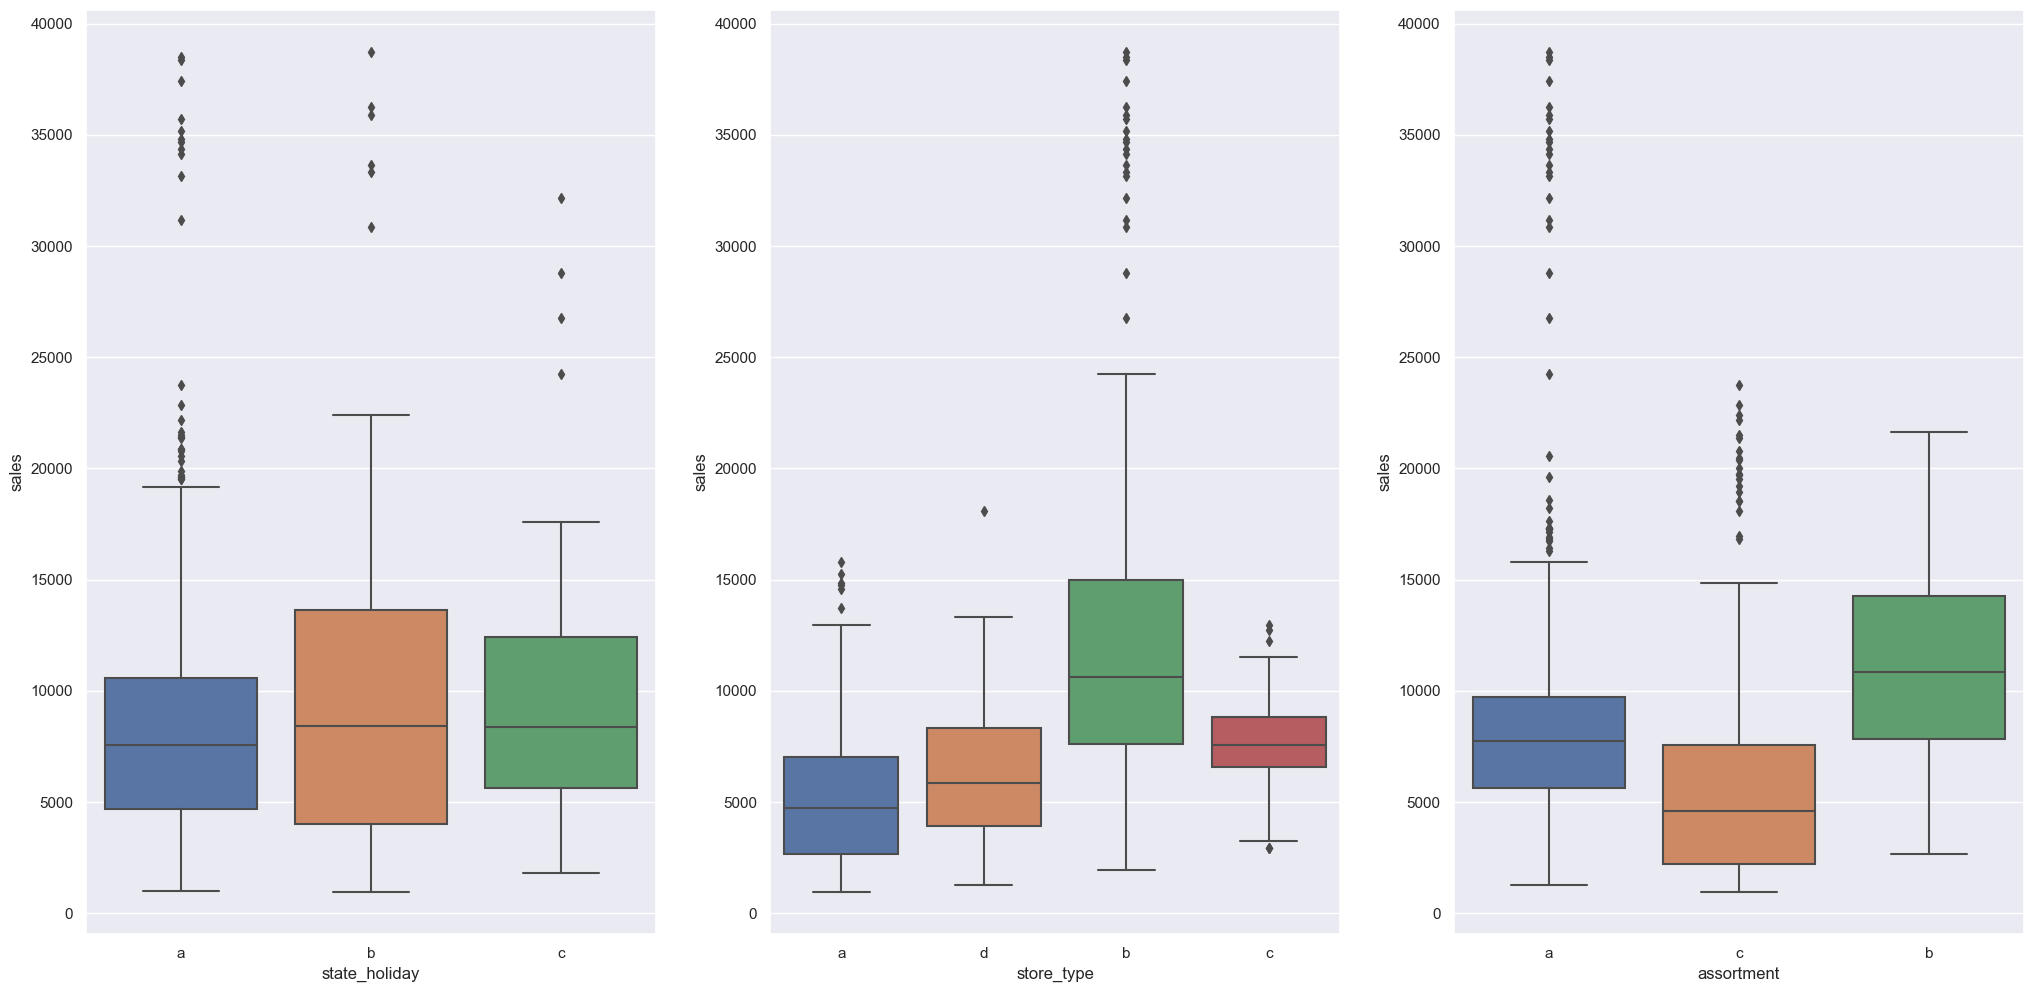

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# Passo 2. FEATURE ENGINEERING

## 2.0. Data Copy

In [20]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

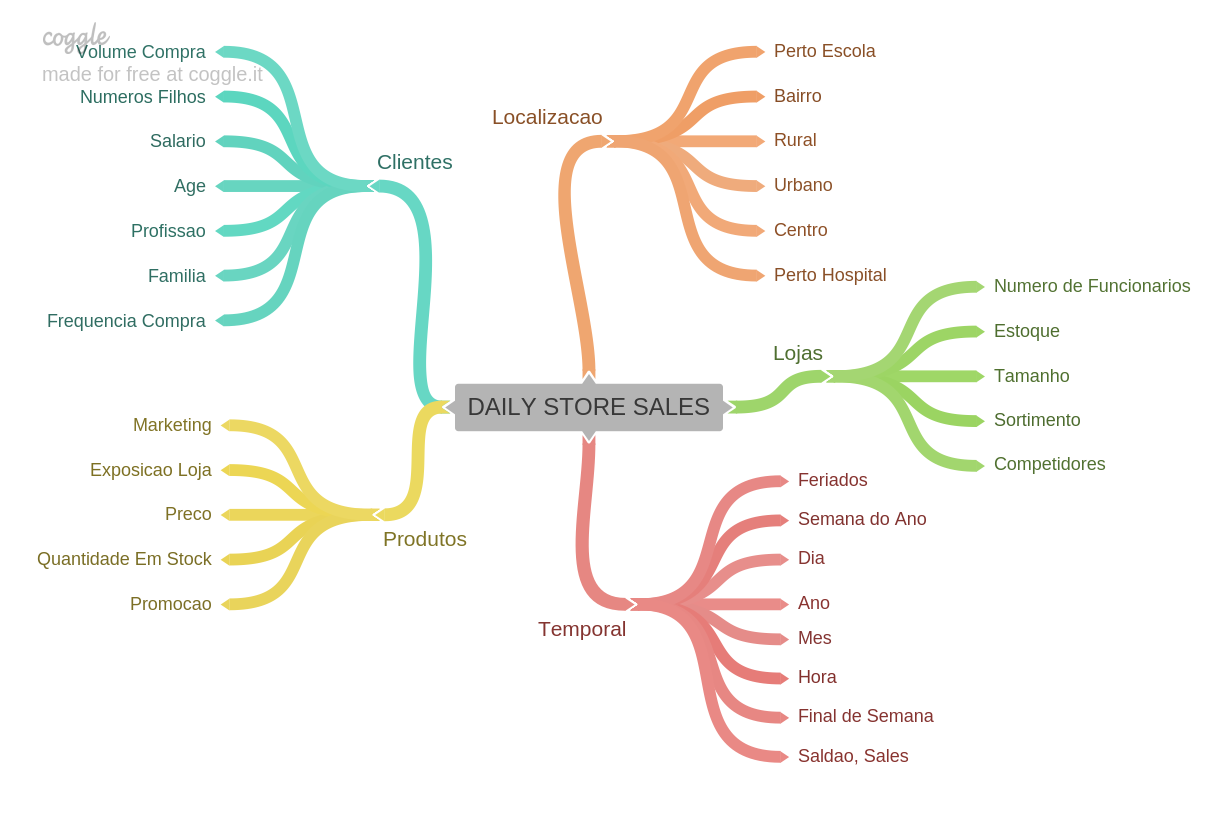

In [21]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criação das Hipóteses

### 2.2.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menore deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final das Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype( int64 )
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] ) / 30).apply( lambda x: x.days ).astype( int64 )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime ( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int64 )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [24]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# Passo 3. FILTRAGEM DE VARIÁVEIS

## 3.0 Data Copy

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# Passo 4. ANÁLISE EXPLORATÓRIA DOS DADOS

## 4.0 Data Copy

In [31]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

<Axes: xlabel='sales', ylabel='Count'>

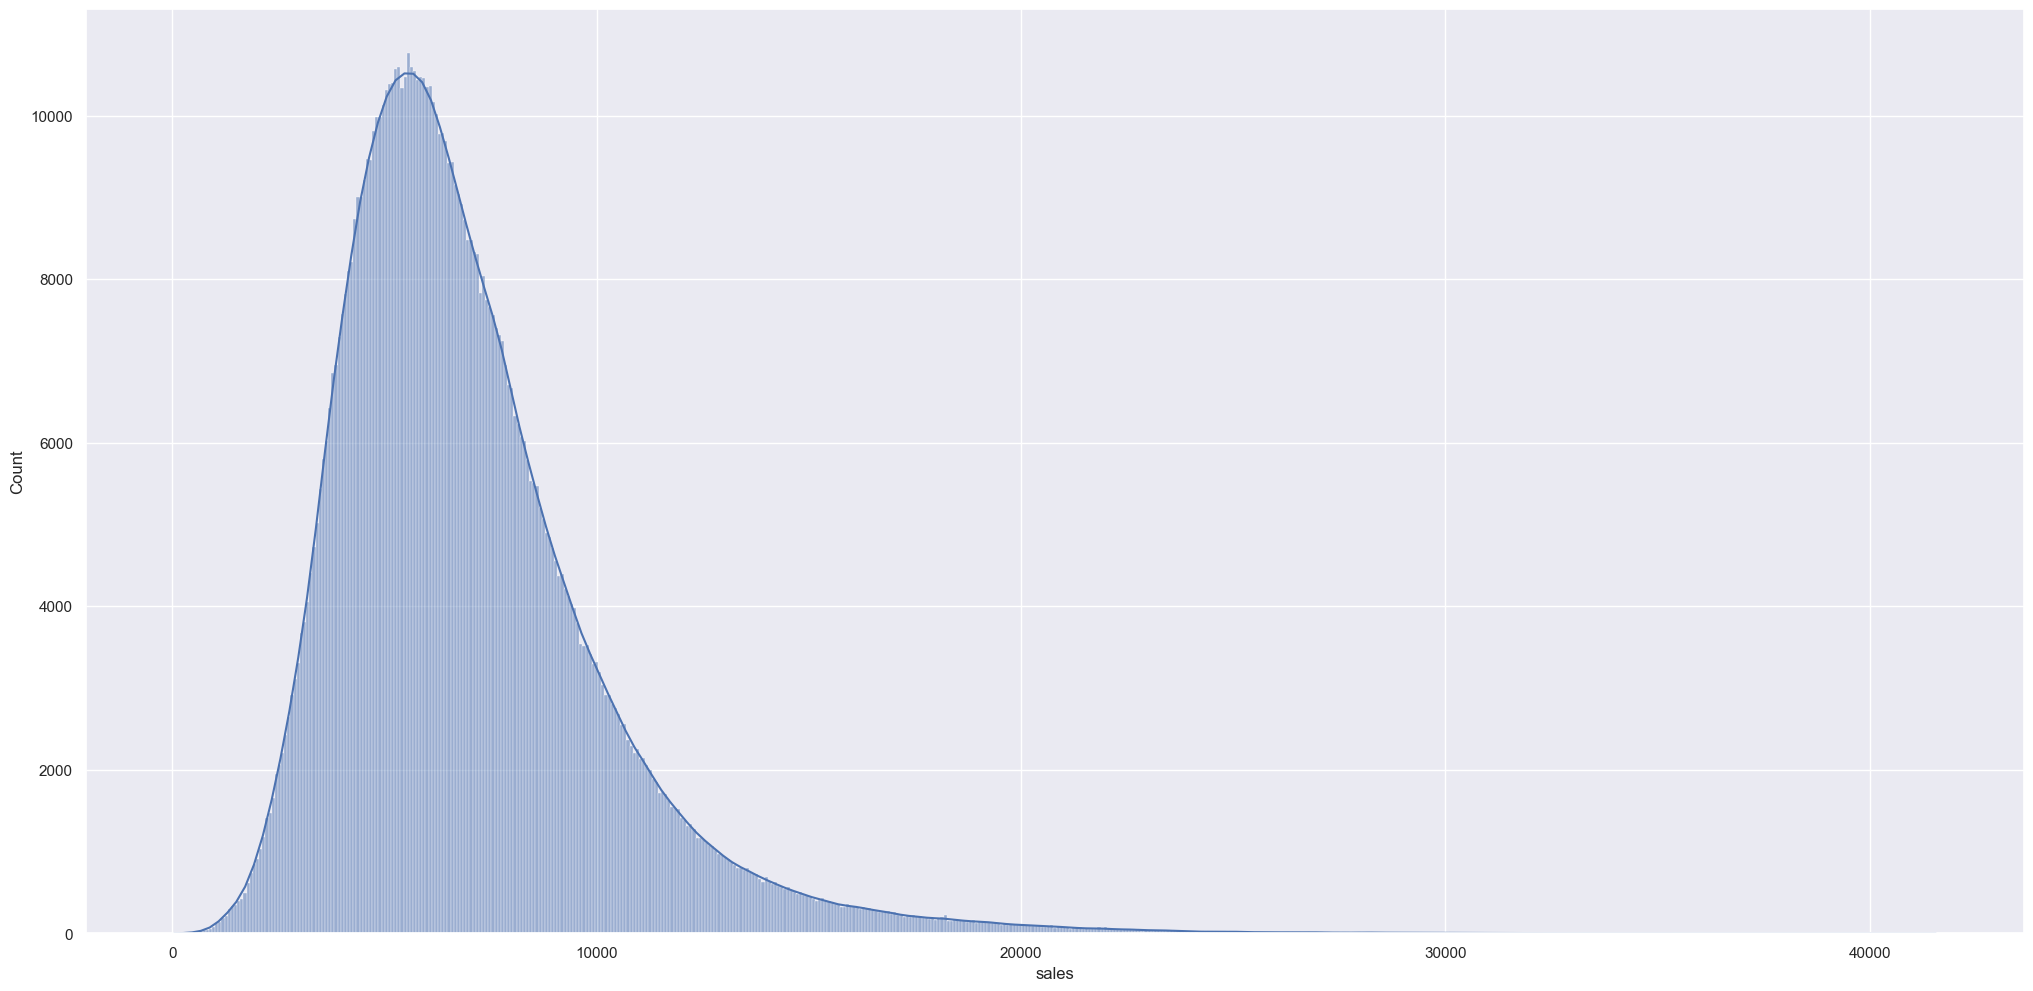

In [32]:
sns.histplot( df4['sales'], kde=True )

### 4.1.2. Numerical Variable

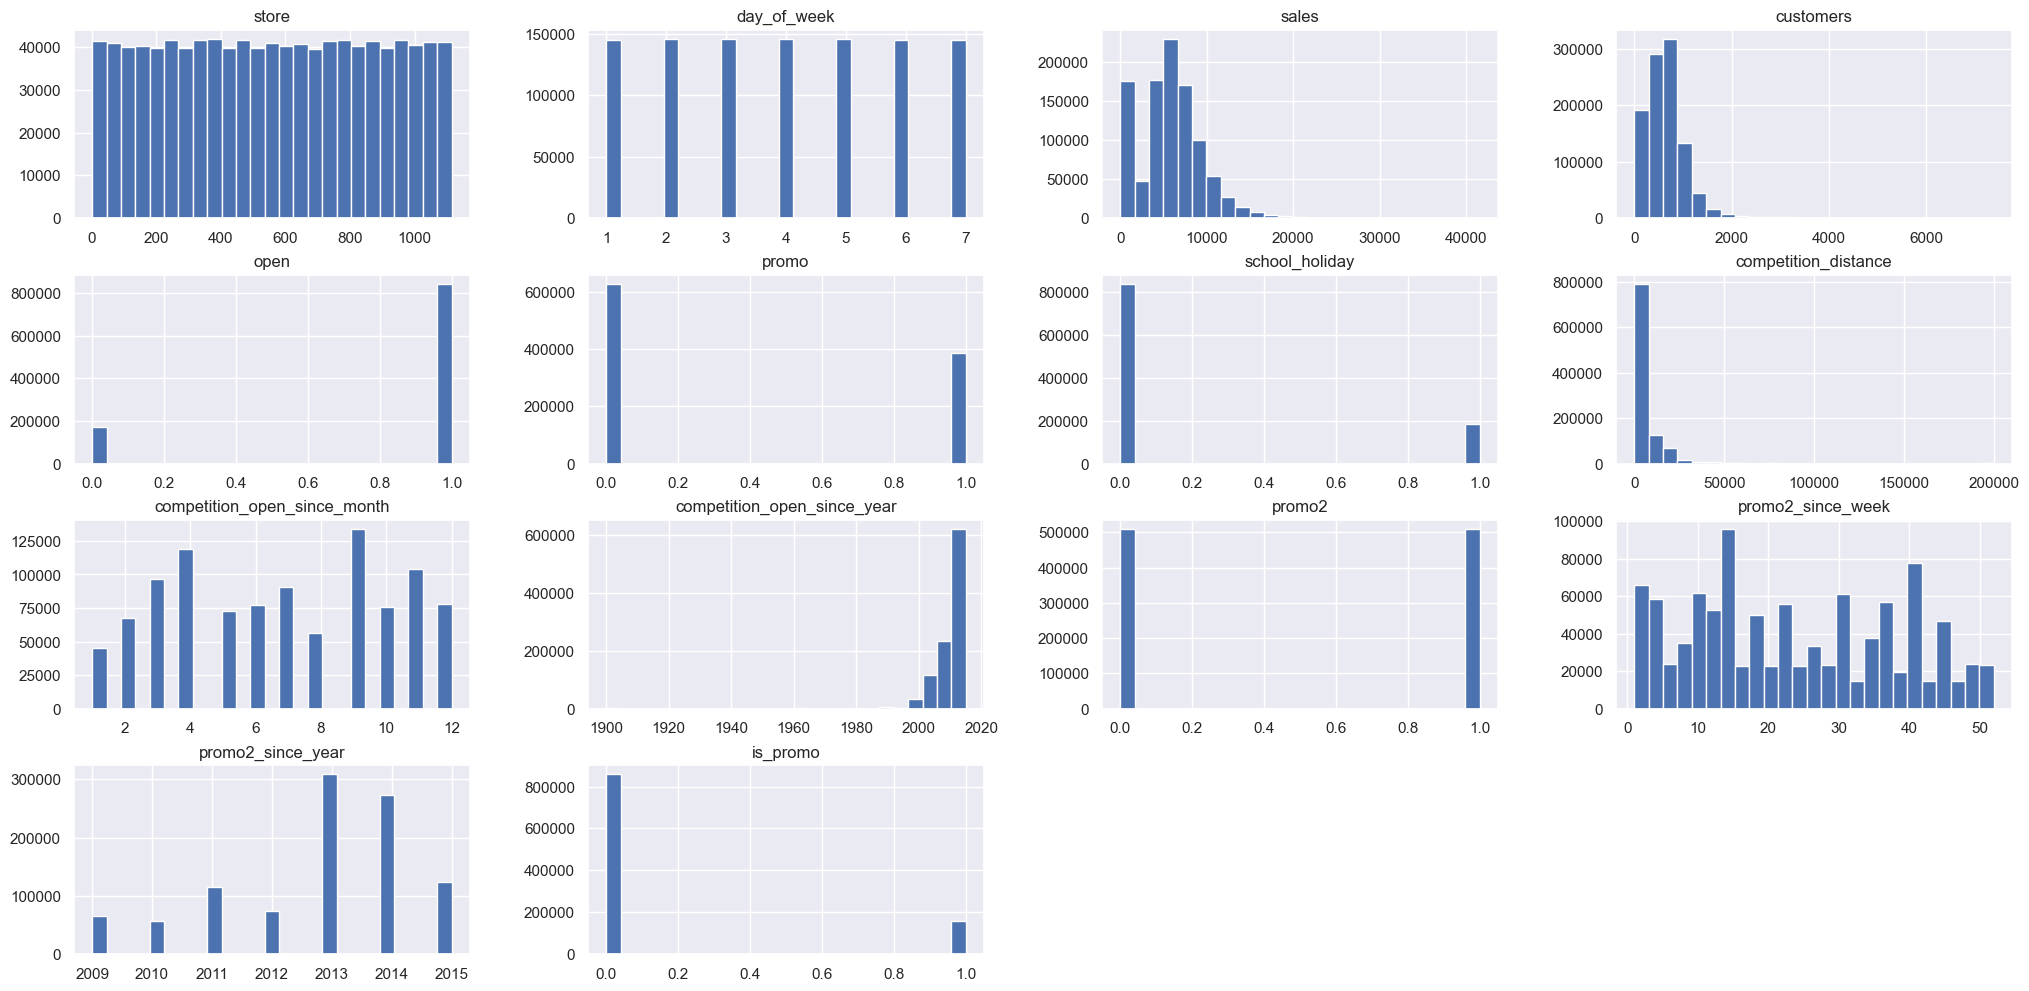

In [33]:
num_attributes.hist( bins=25 );

### 4.1.3. Categorical Variable

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

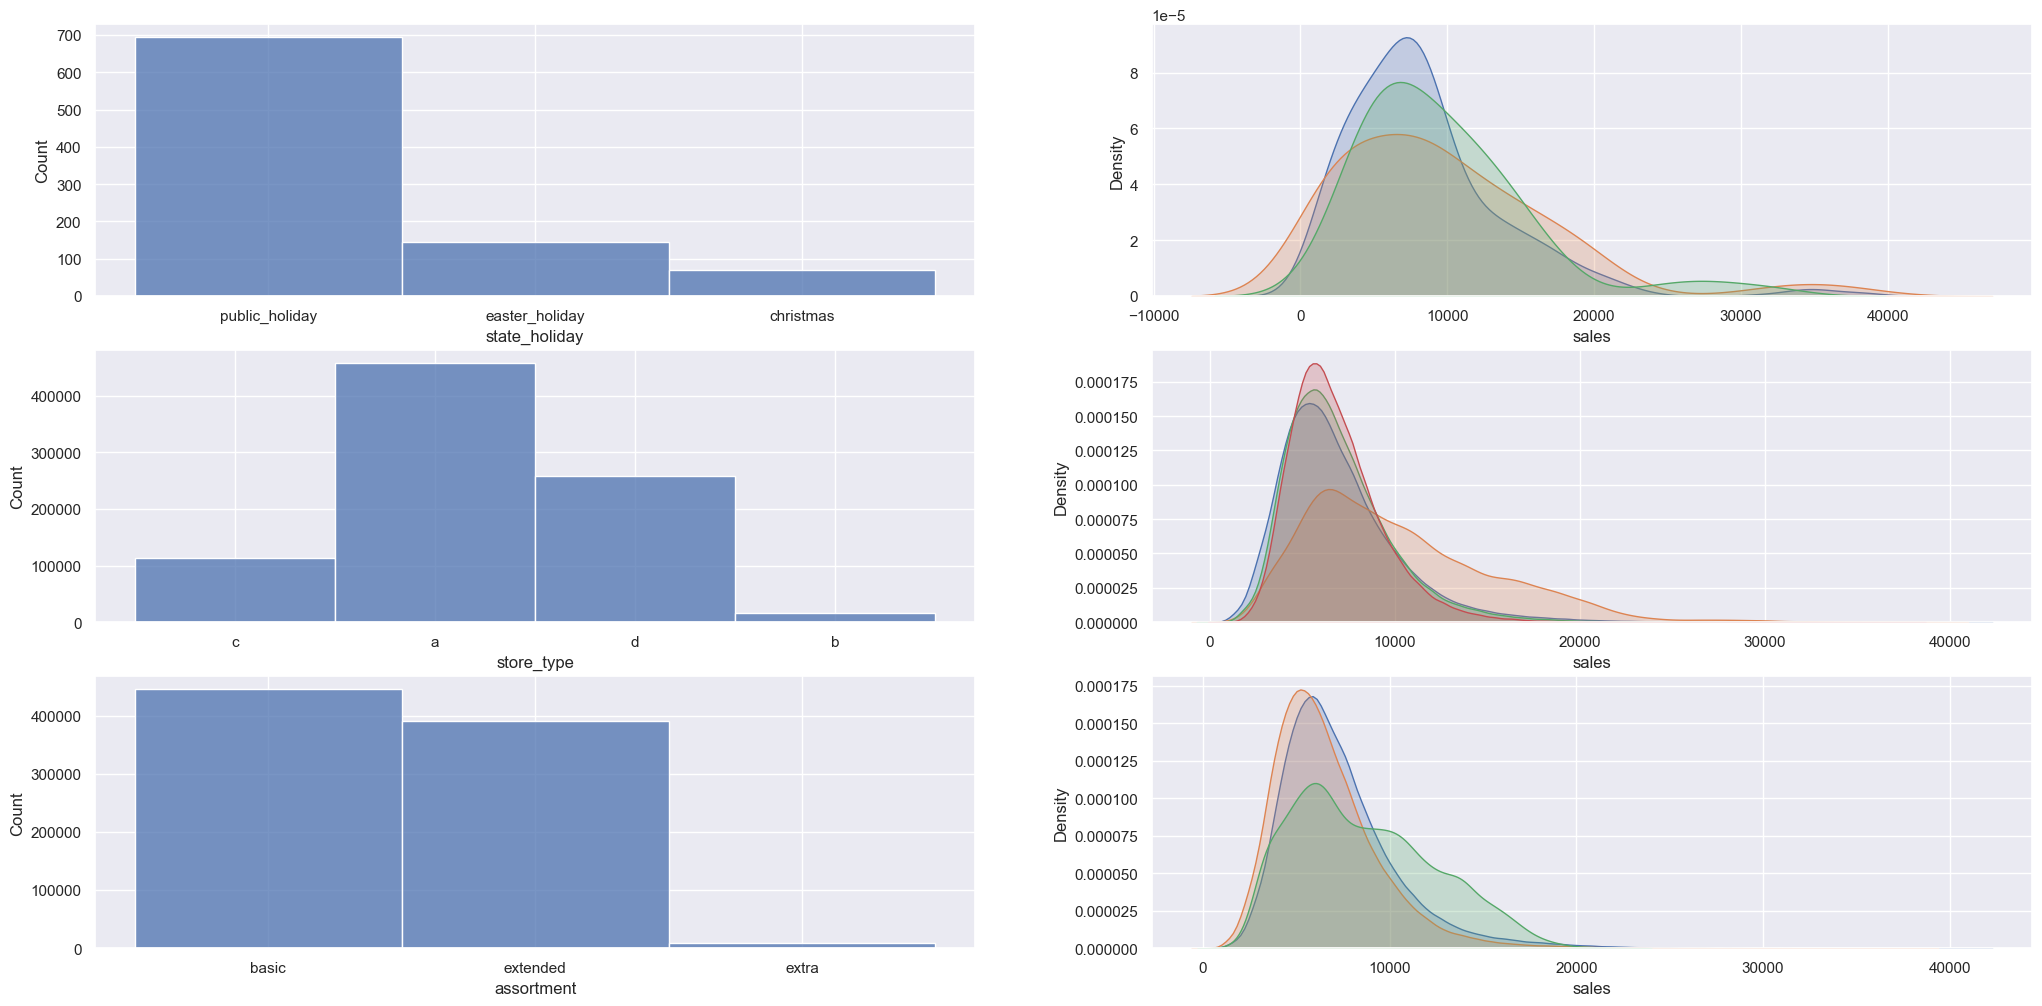

In [35]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.histplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.histplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.histplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
**VERDADEIRA**: Em média, lojas com MAIOR SORTIMENTO vendem MAIS.

<Axes: xlabel='year_week'>

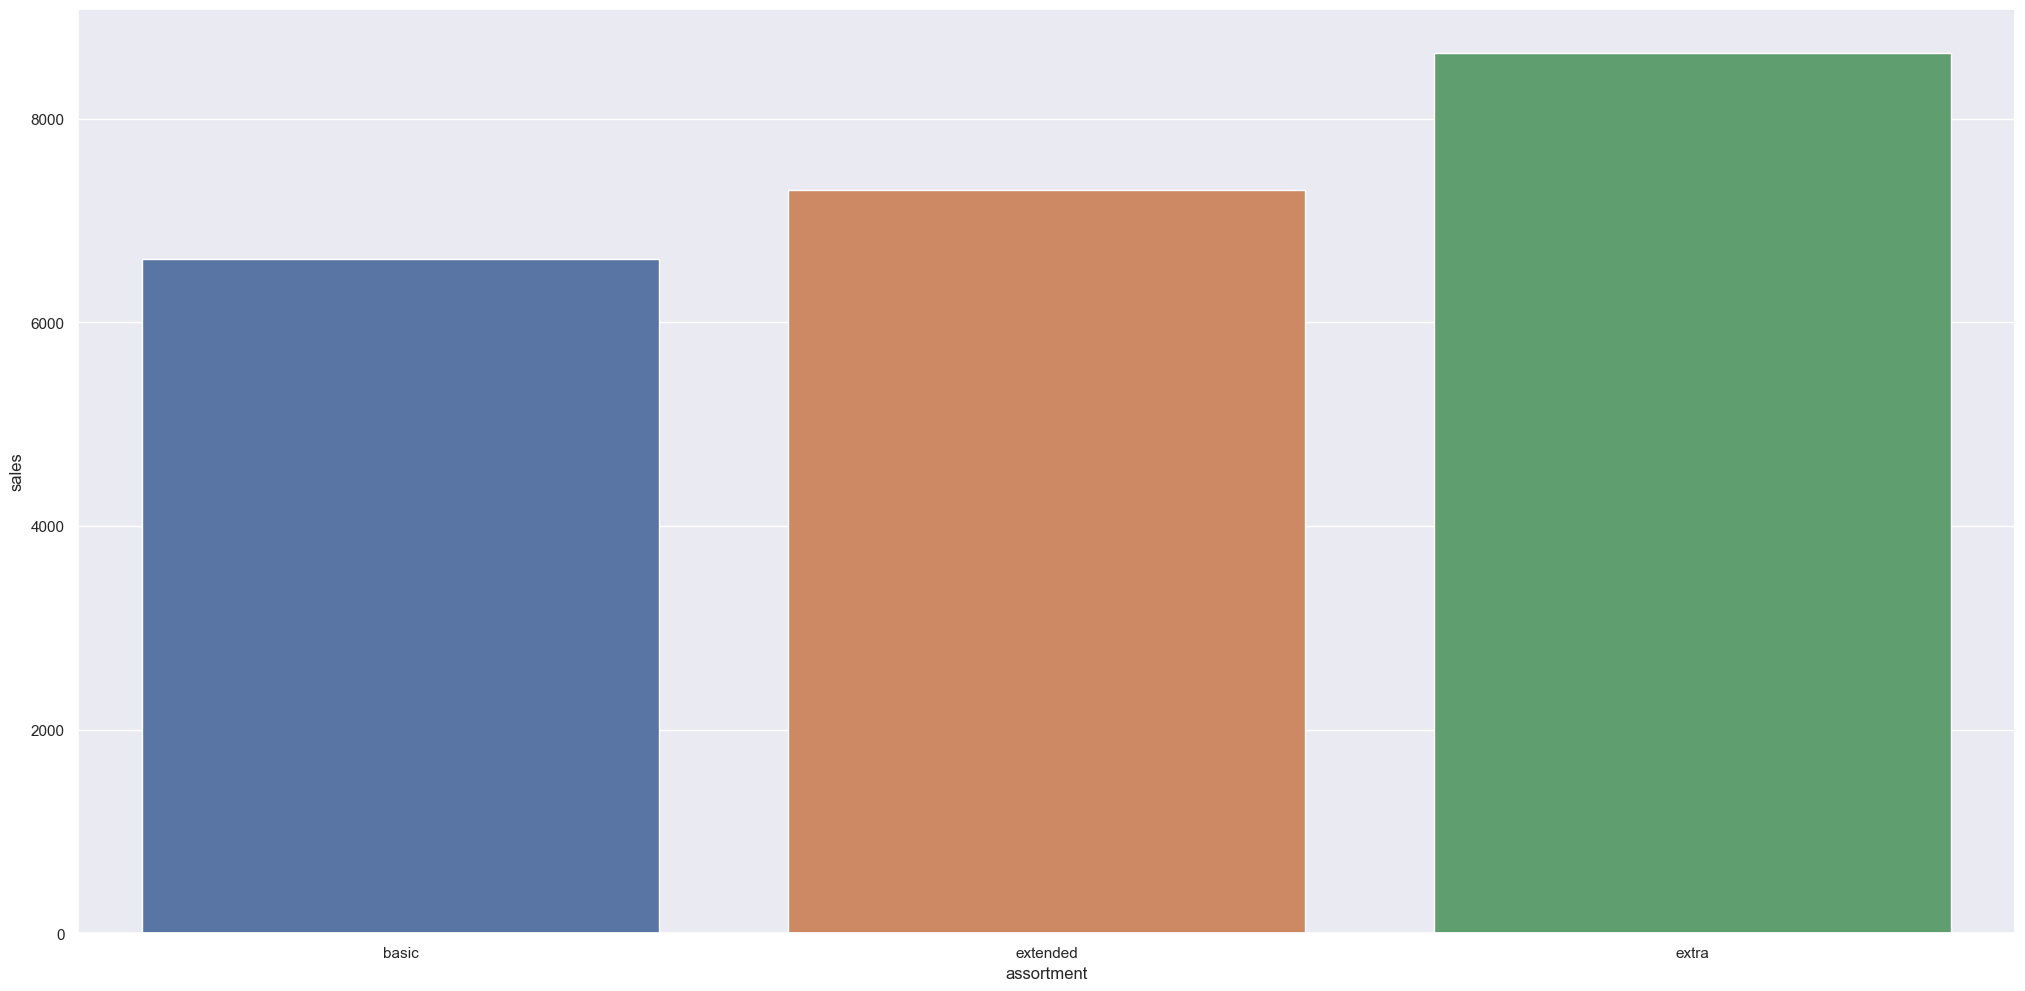

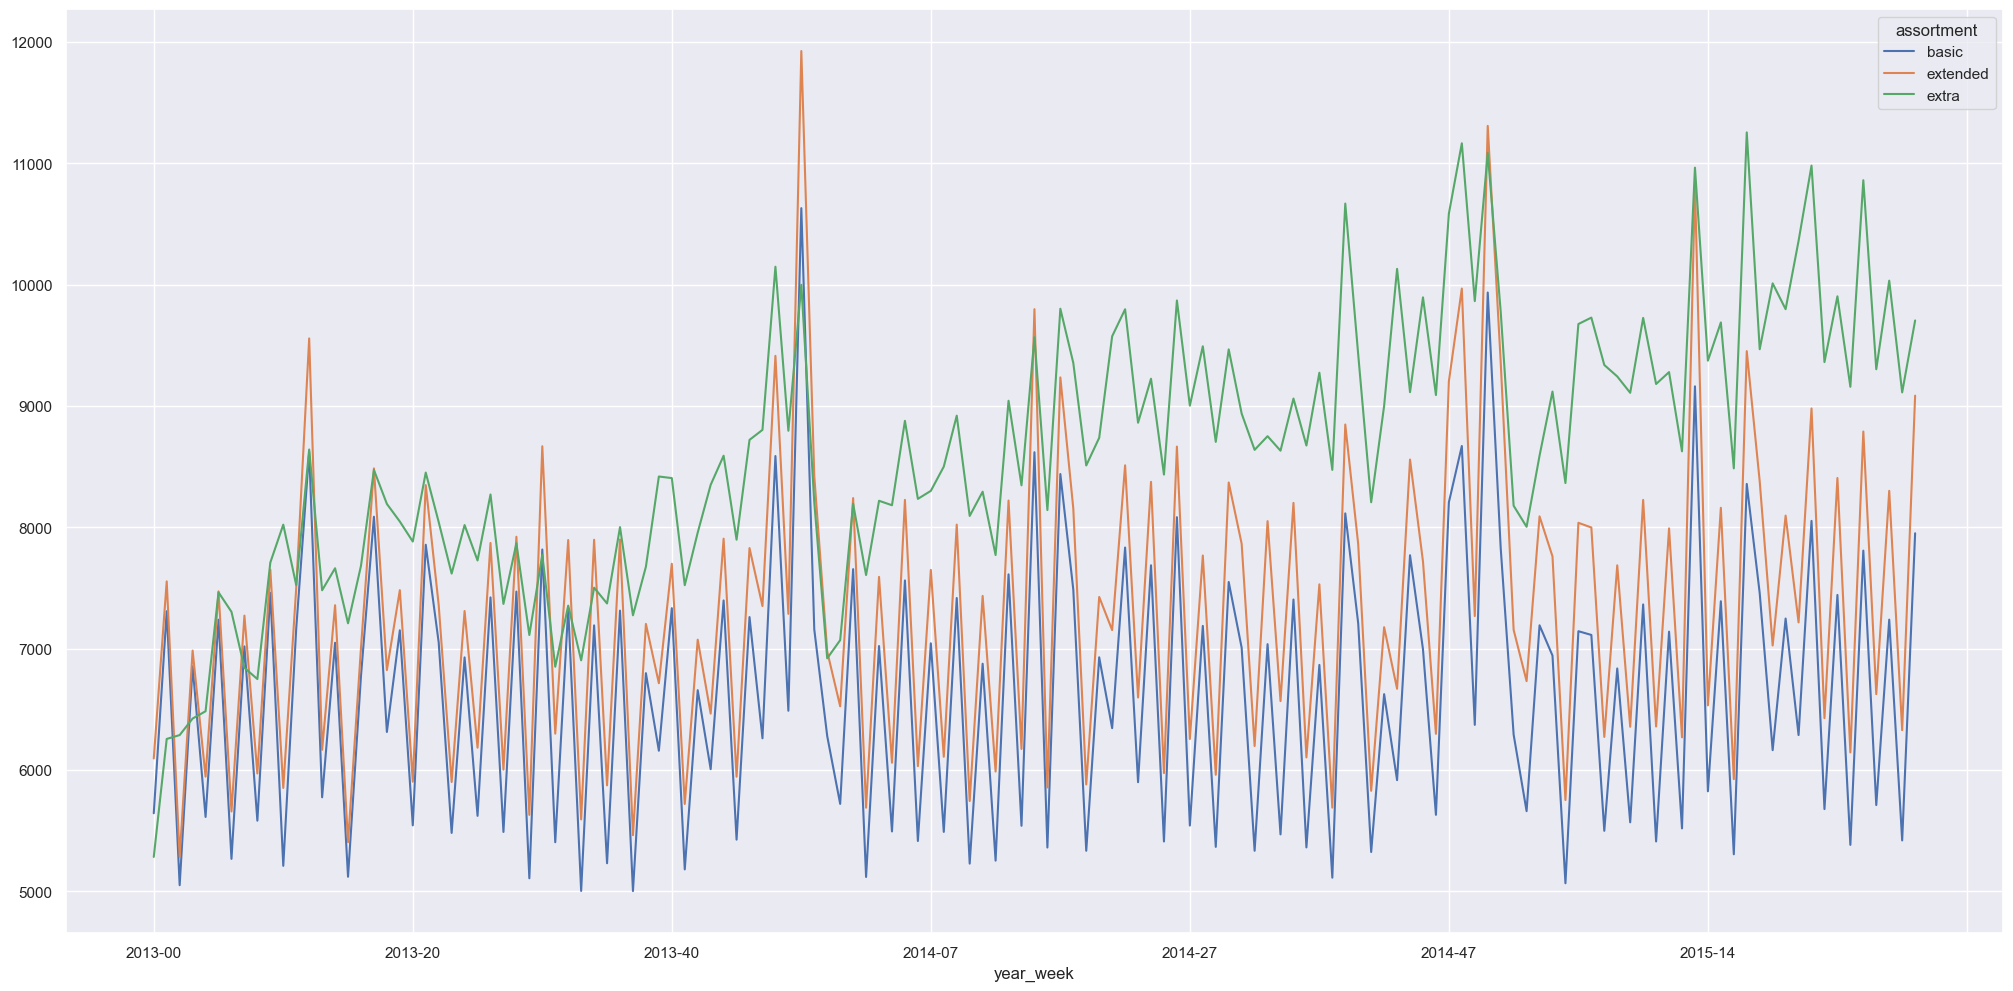

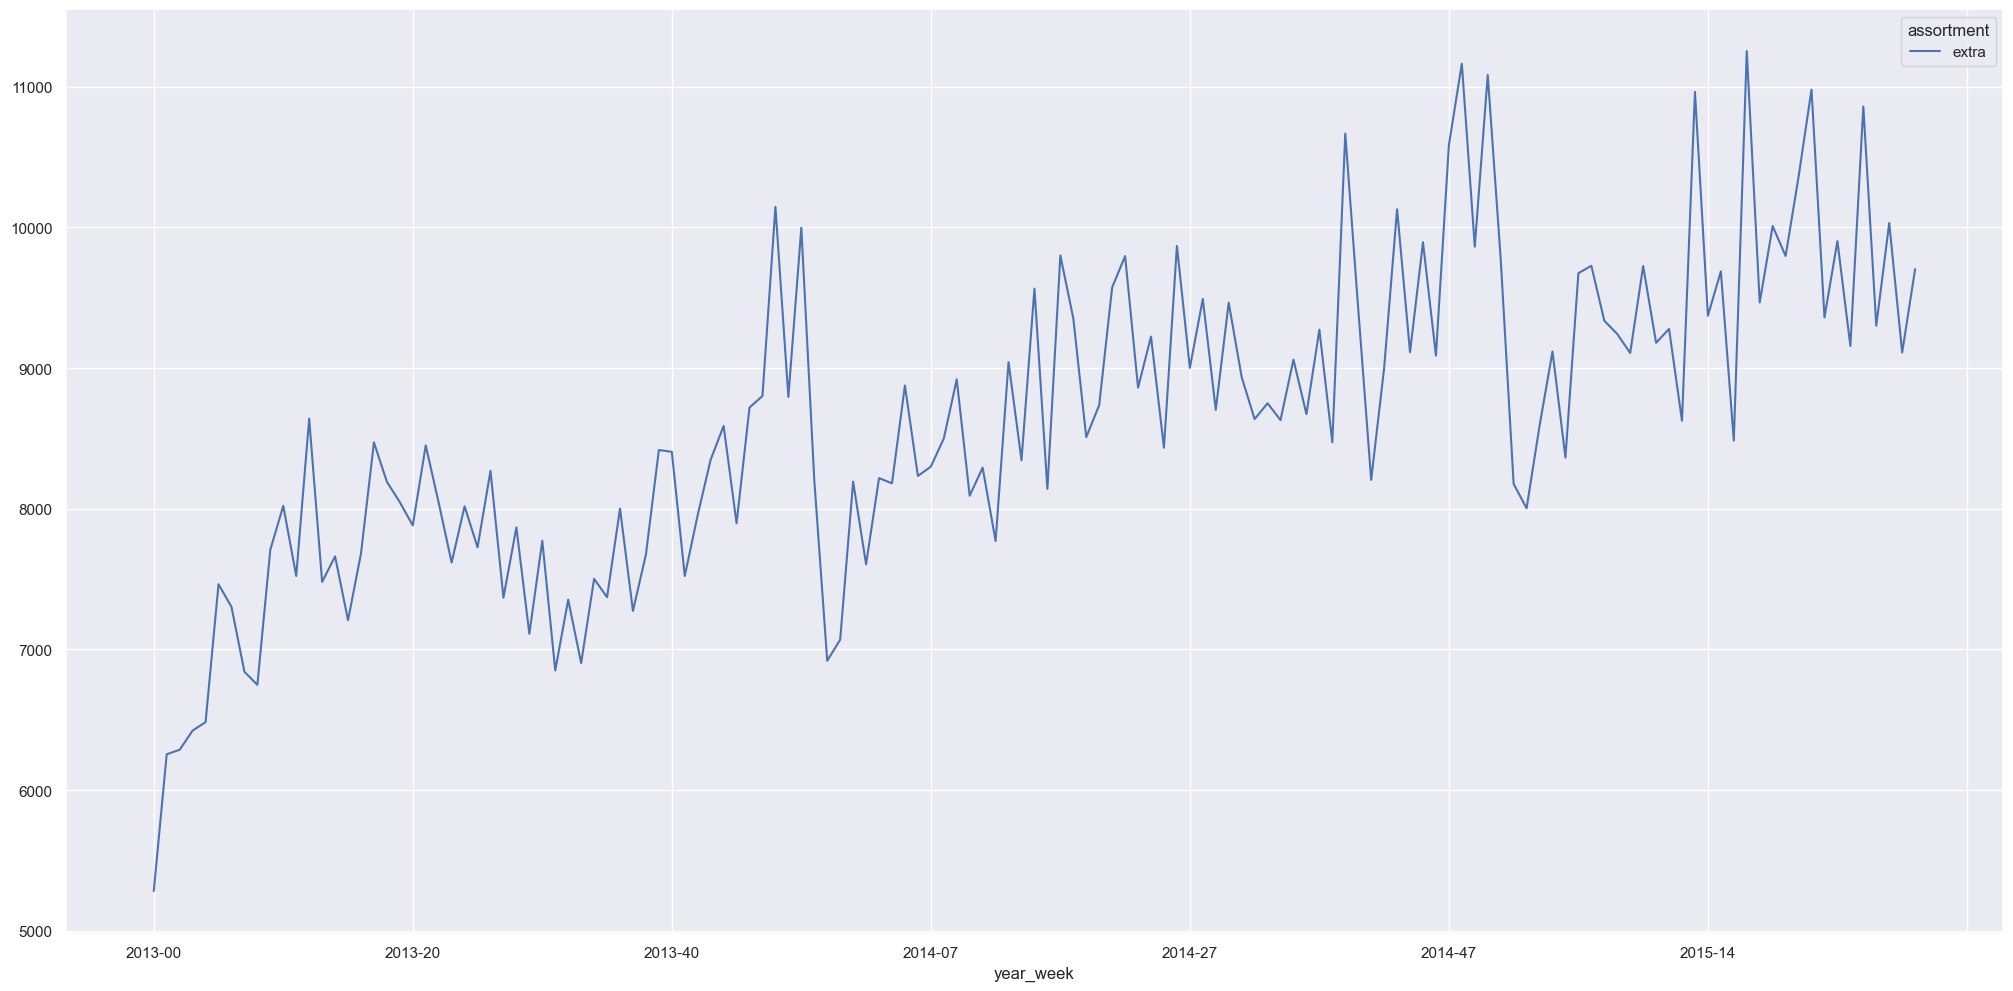

In [36]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**VERDADEIRA**: Em média, lojas com COMPETIDORES MAIS PRÓXIMOS vendem MENOS.

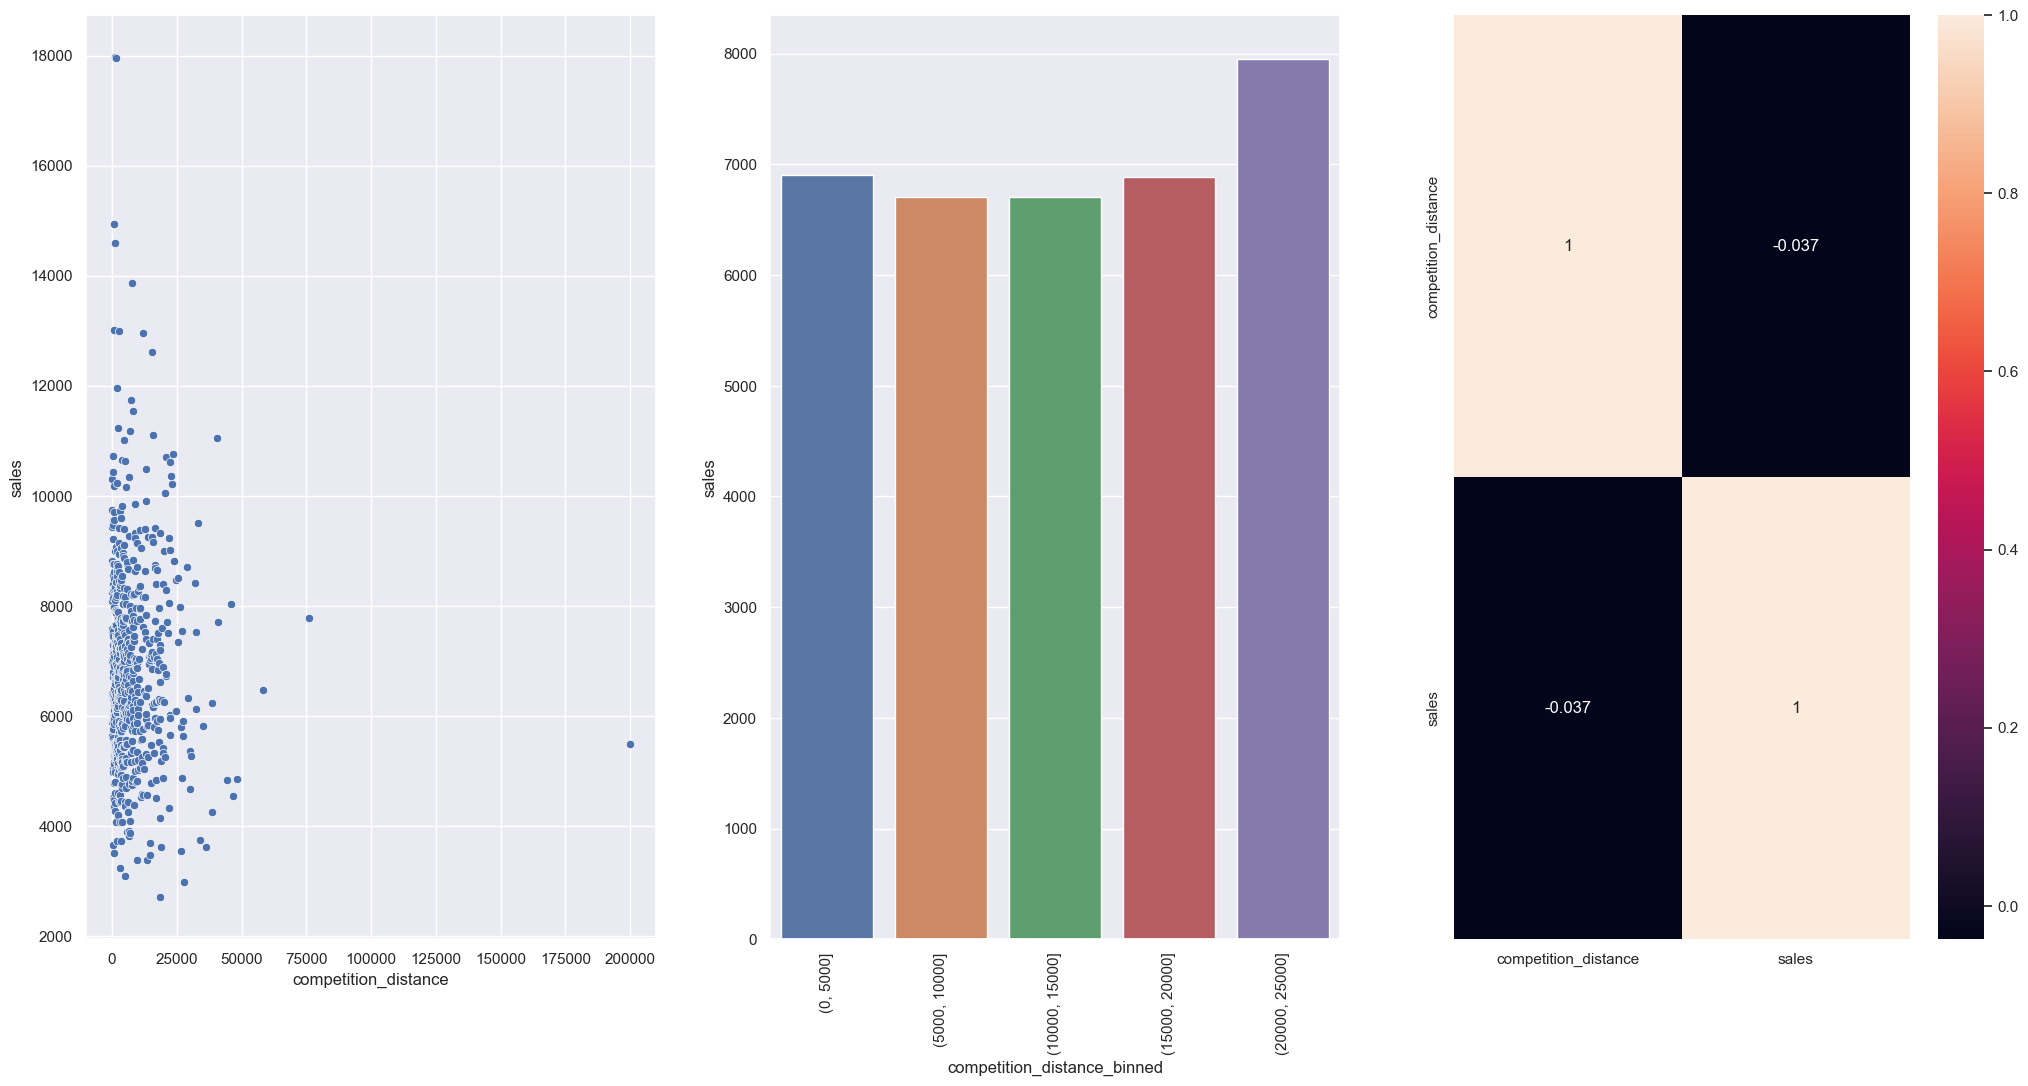

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list(np.arange(0, 30000, 5000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson', numeric_only=True ), annot=True );


### H3. Lojas com competidores há mais tempo deveriam vender mais.
**FALSA**: Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS.

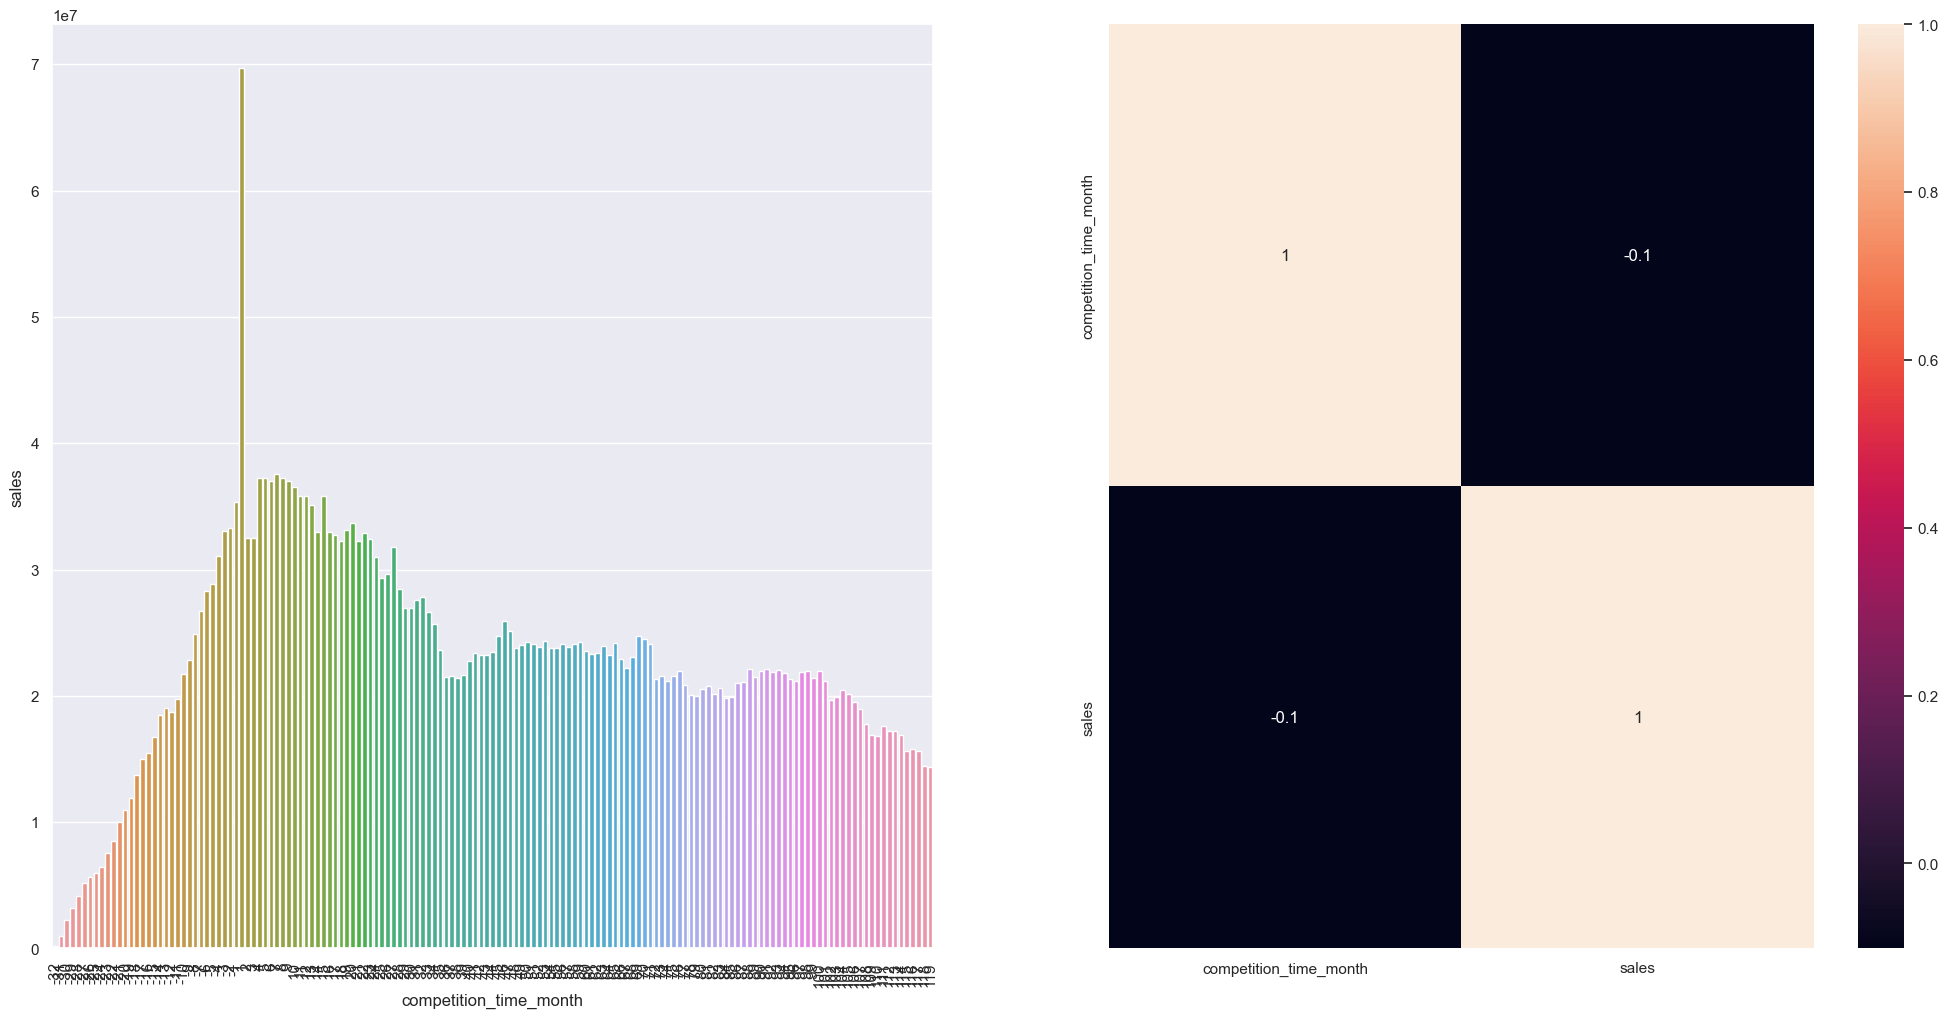

In [38]:
plt.subplot( 1, 2, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot( 1, 2, 2)
x = sns.heatmap( aux1.corr( method='pearson', numeric_only=True ), annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA**: Lojas com promoções ativas por mis tempo vendem menos depois de um certo período de promoção.

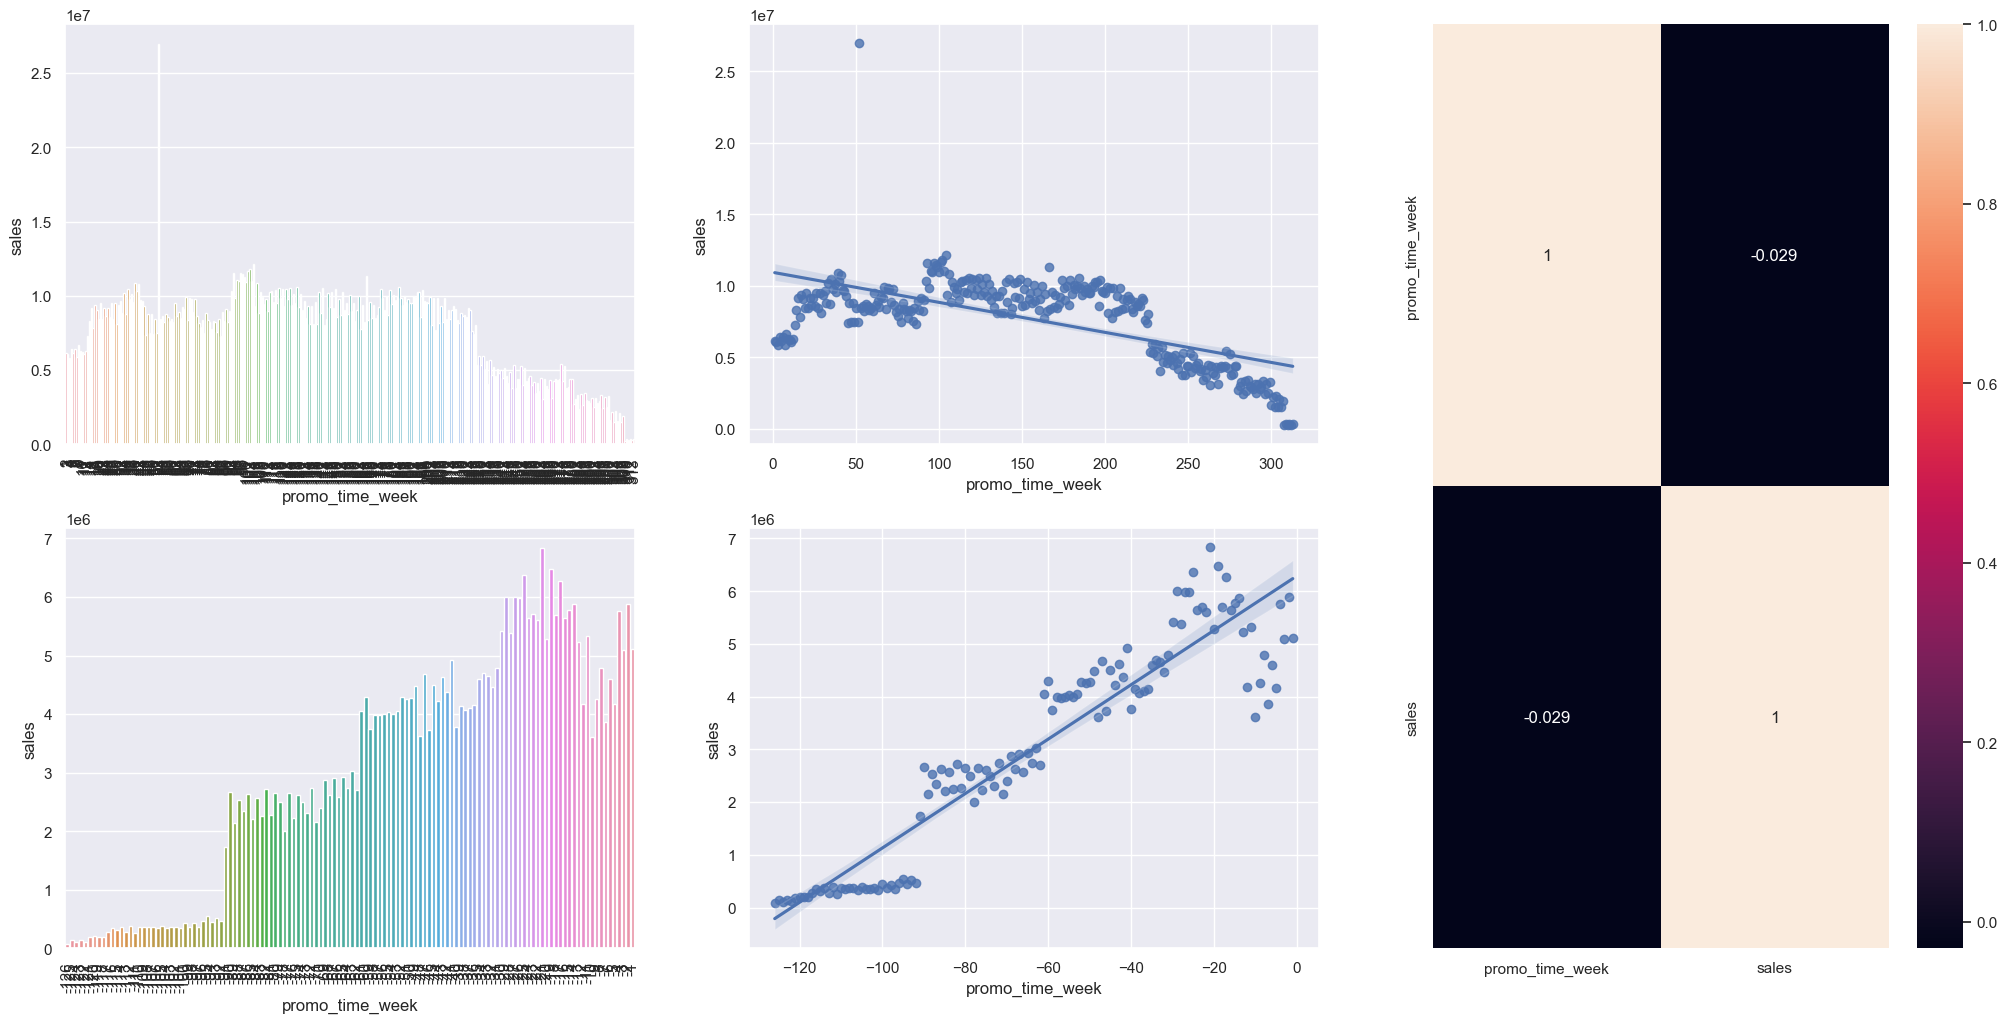

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson', numeric_only=True ), annot=True );

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA**: Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS.

In [40]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


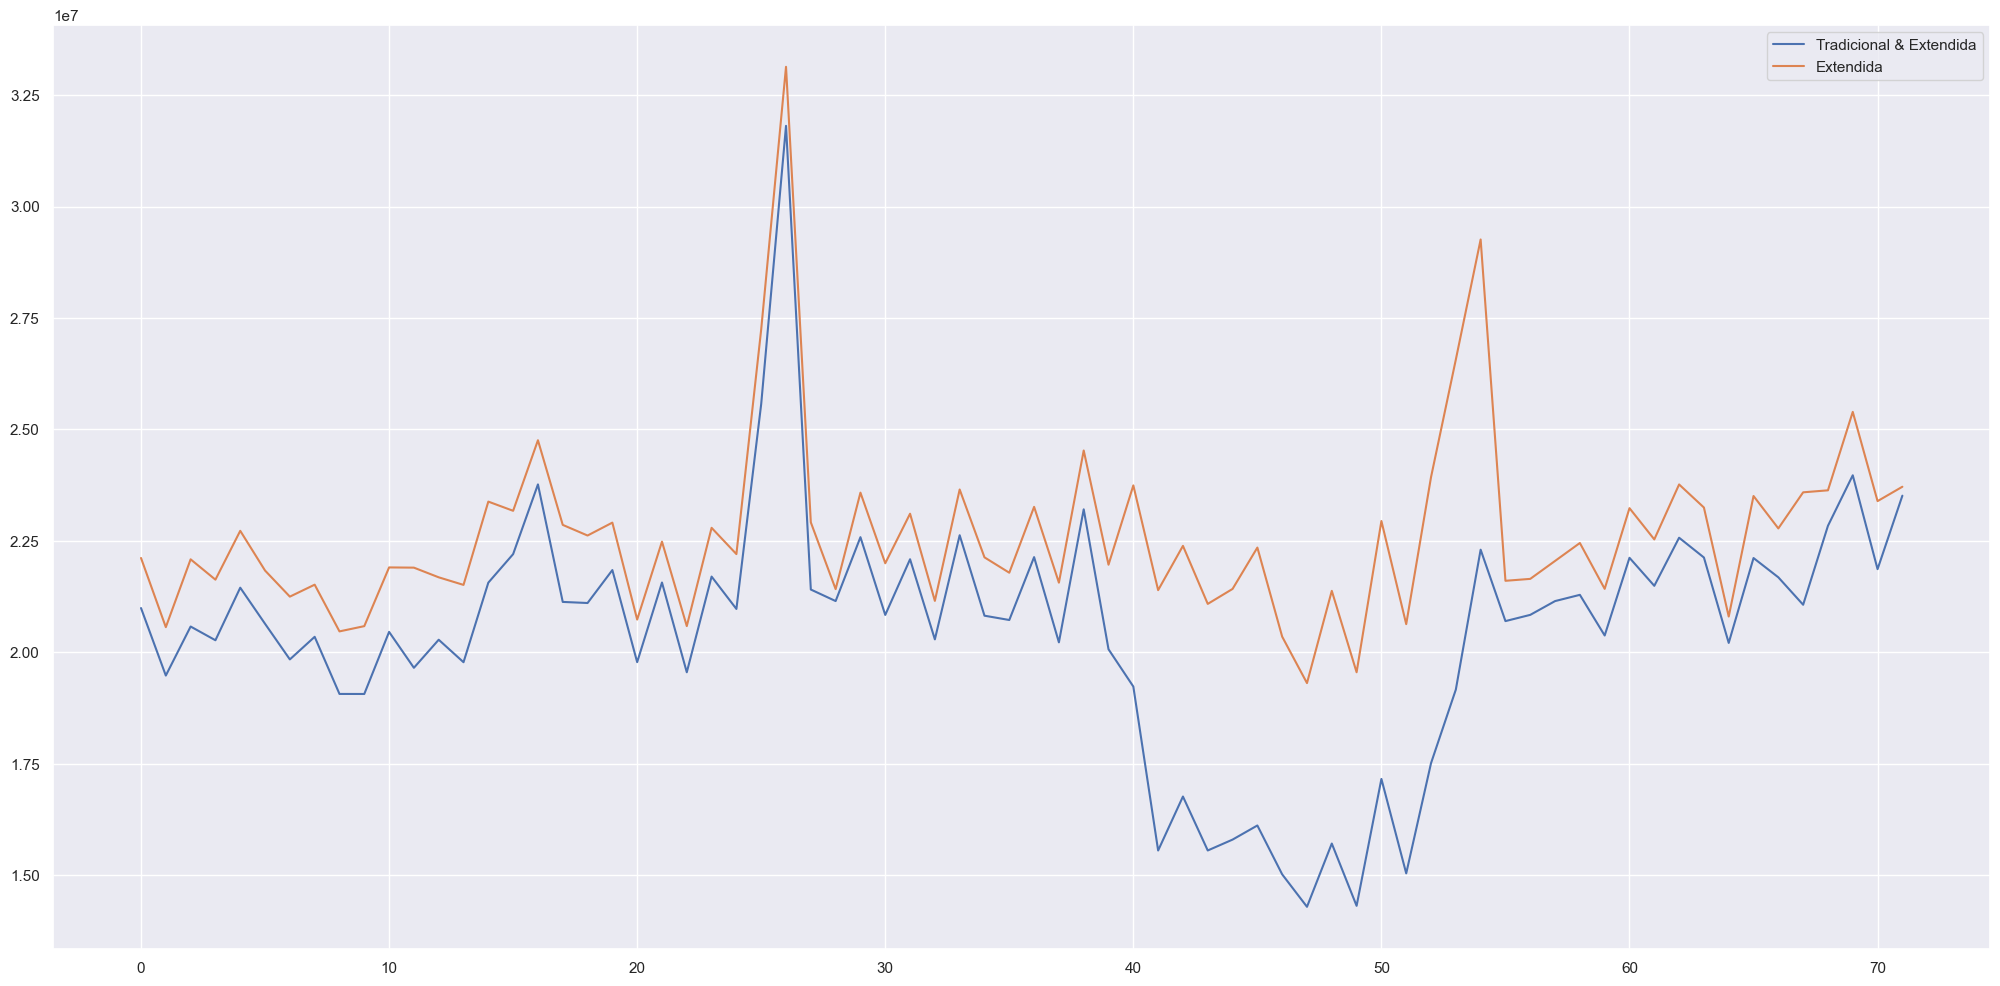

In [41]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**VERDADEIRA**: Em média, lojas abertas durante o feriado de Natal vendem MAIS do que nos demais feriados, com exceção a páscoa de 2013.

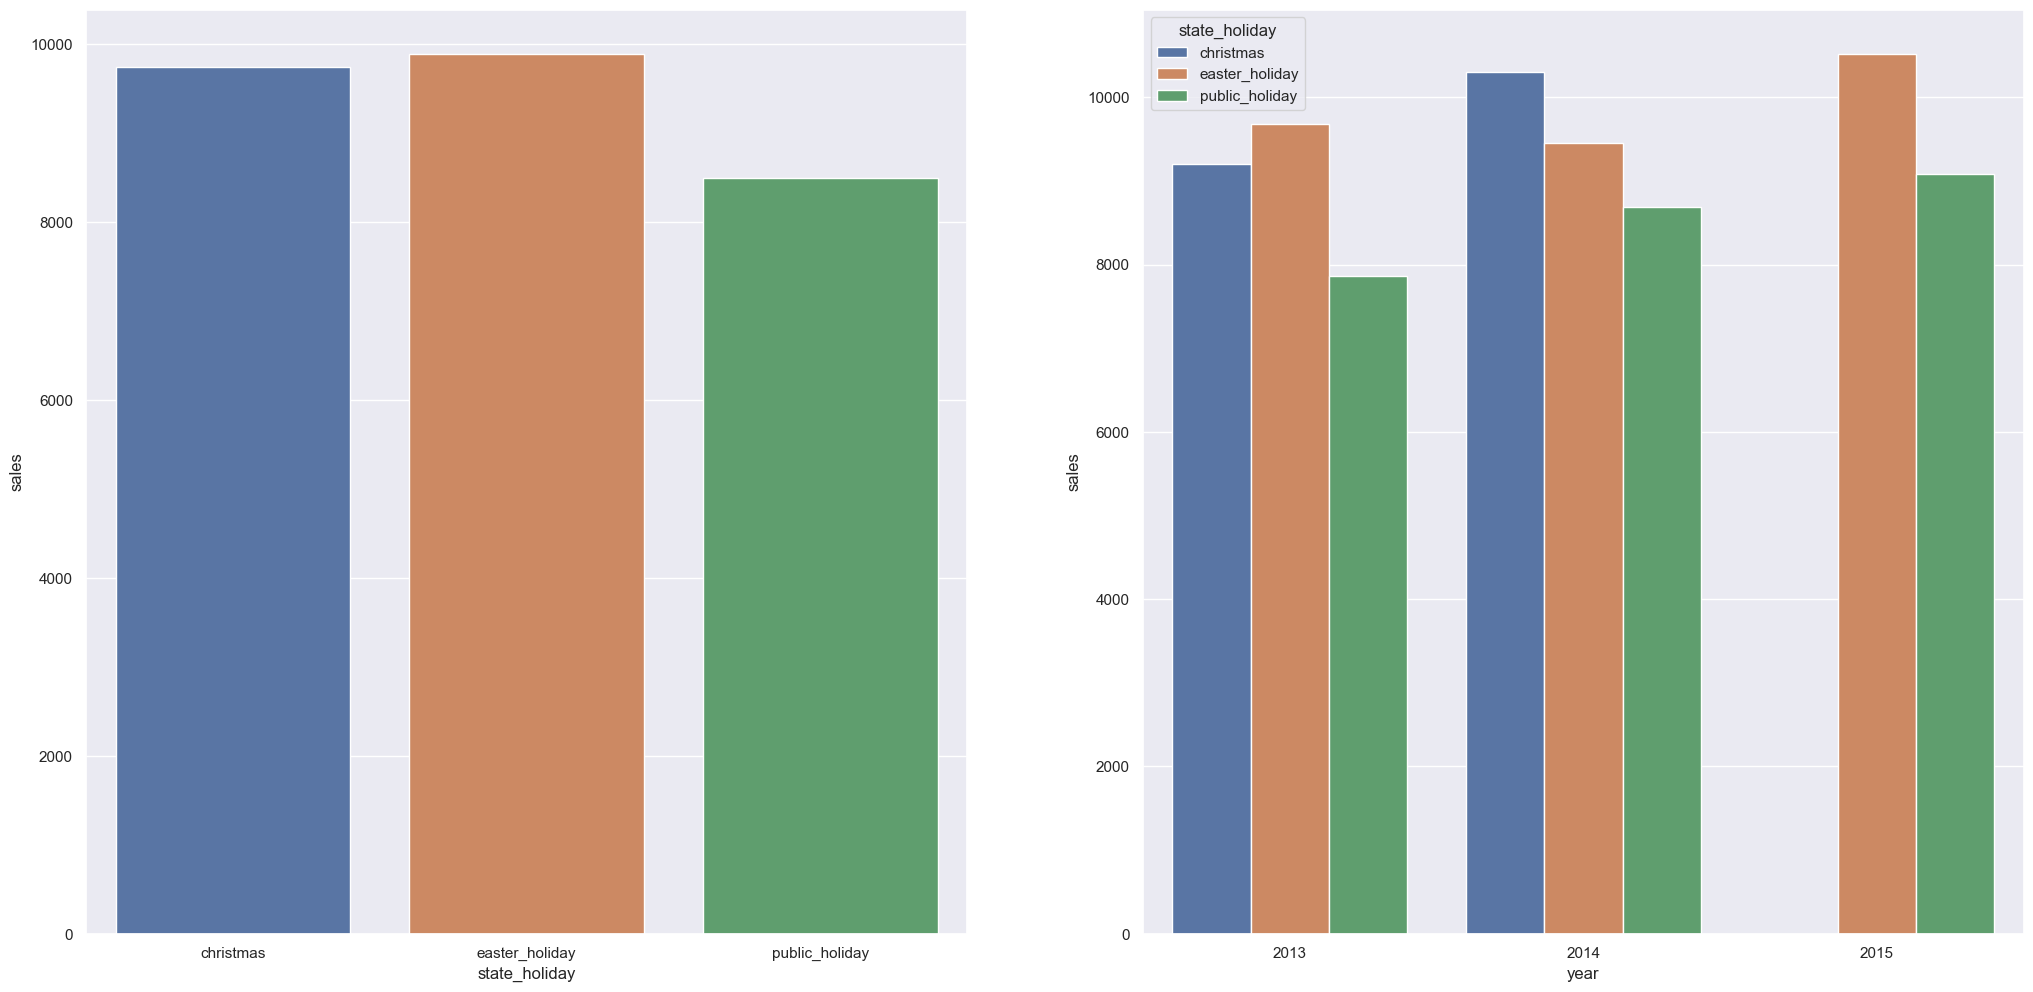

In [42]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA**: Lojas VENDEM MENOS ao longo dos ANOS.

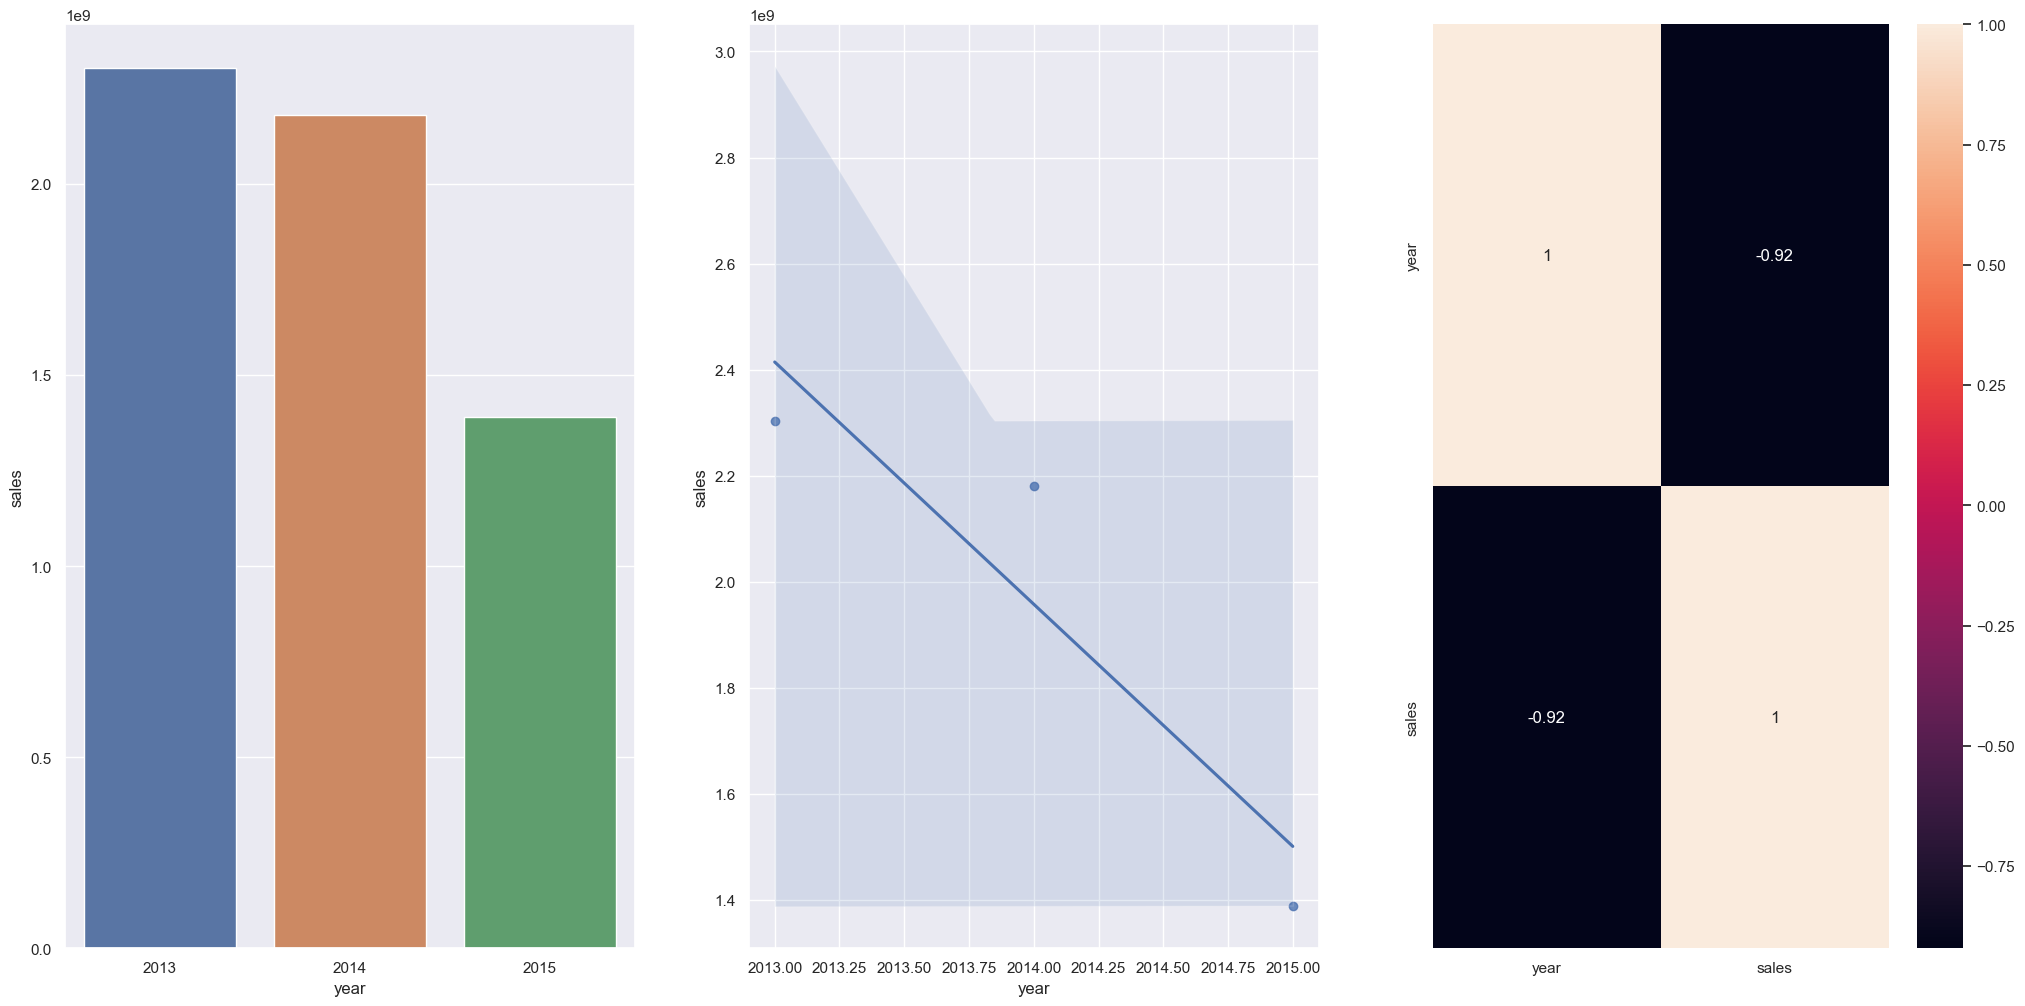

In [43]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson',  numeric_only=True ), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**: Mesmo se desconsideramos 2015, lojas NÃO VENDEM mais no segundo semestre.

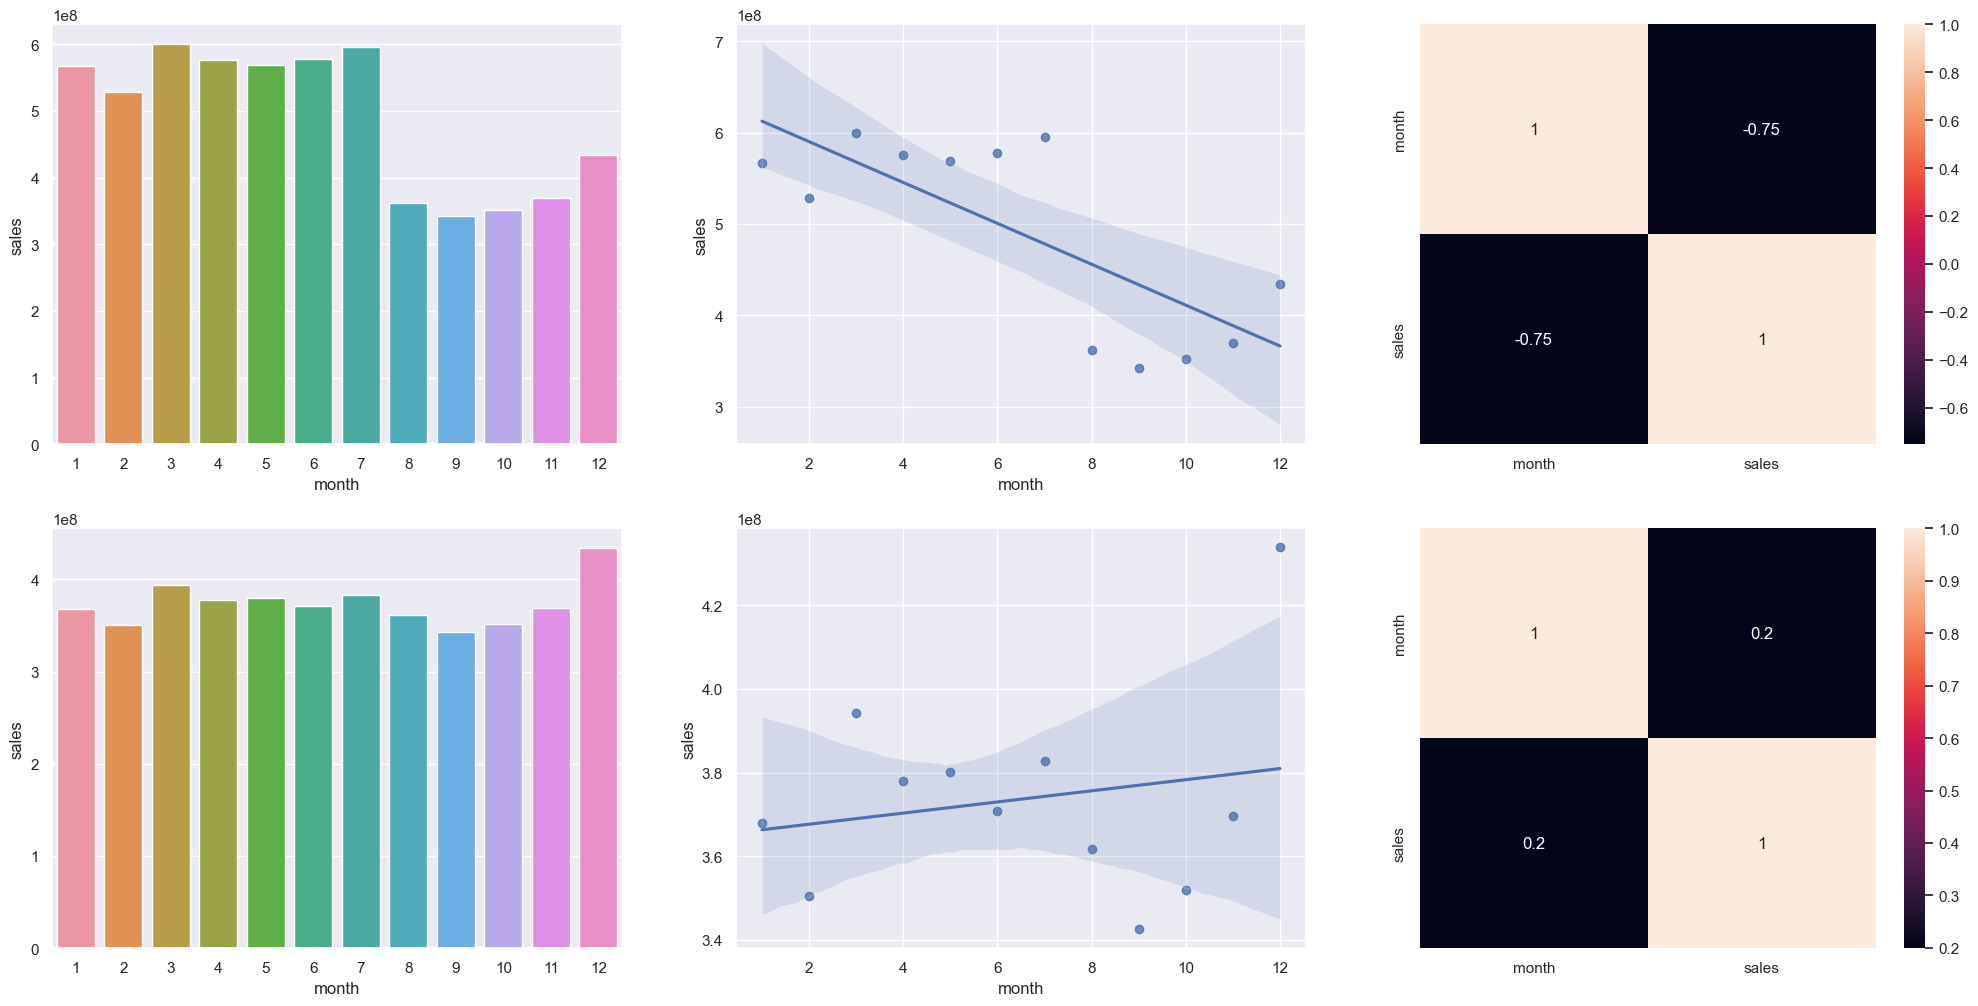

In [44]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 2, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 2, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 2, 3, 3 )
sns.heatmap( aux1.corr( method='pearson', numeric_only=True ), annot=True );

## desconsiderando 2015
aux2 = df4[df4['year'] != 2015][['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 2, 3, 4 )
sns.barplot( x='month', y='sales', data=aux2 );

plt.subplot( 2, 3, 5 )
sns.regplot( x='month', y='sales', data=aux2 );

plt.subplot( 2, 3, 6 )
sns.heatmap( aux2.corr( method='pearson', numeric_only=True ), annot=True );

### 10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**: Lojas vendem mais depois do dia 10 de cada mês.

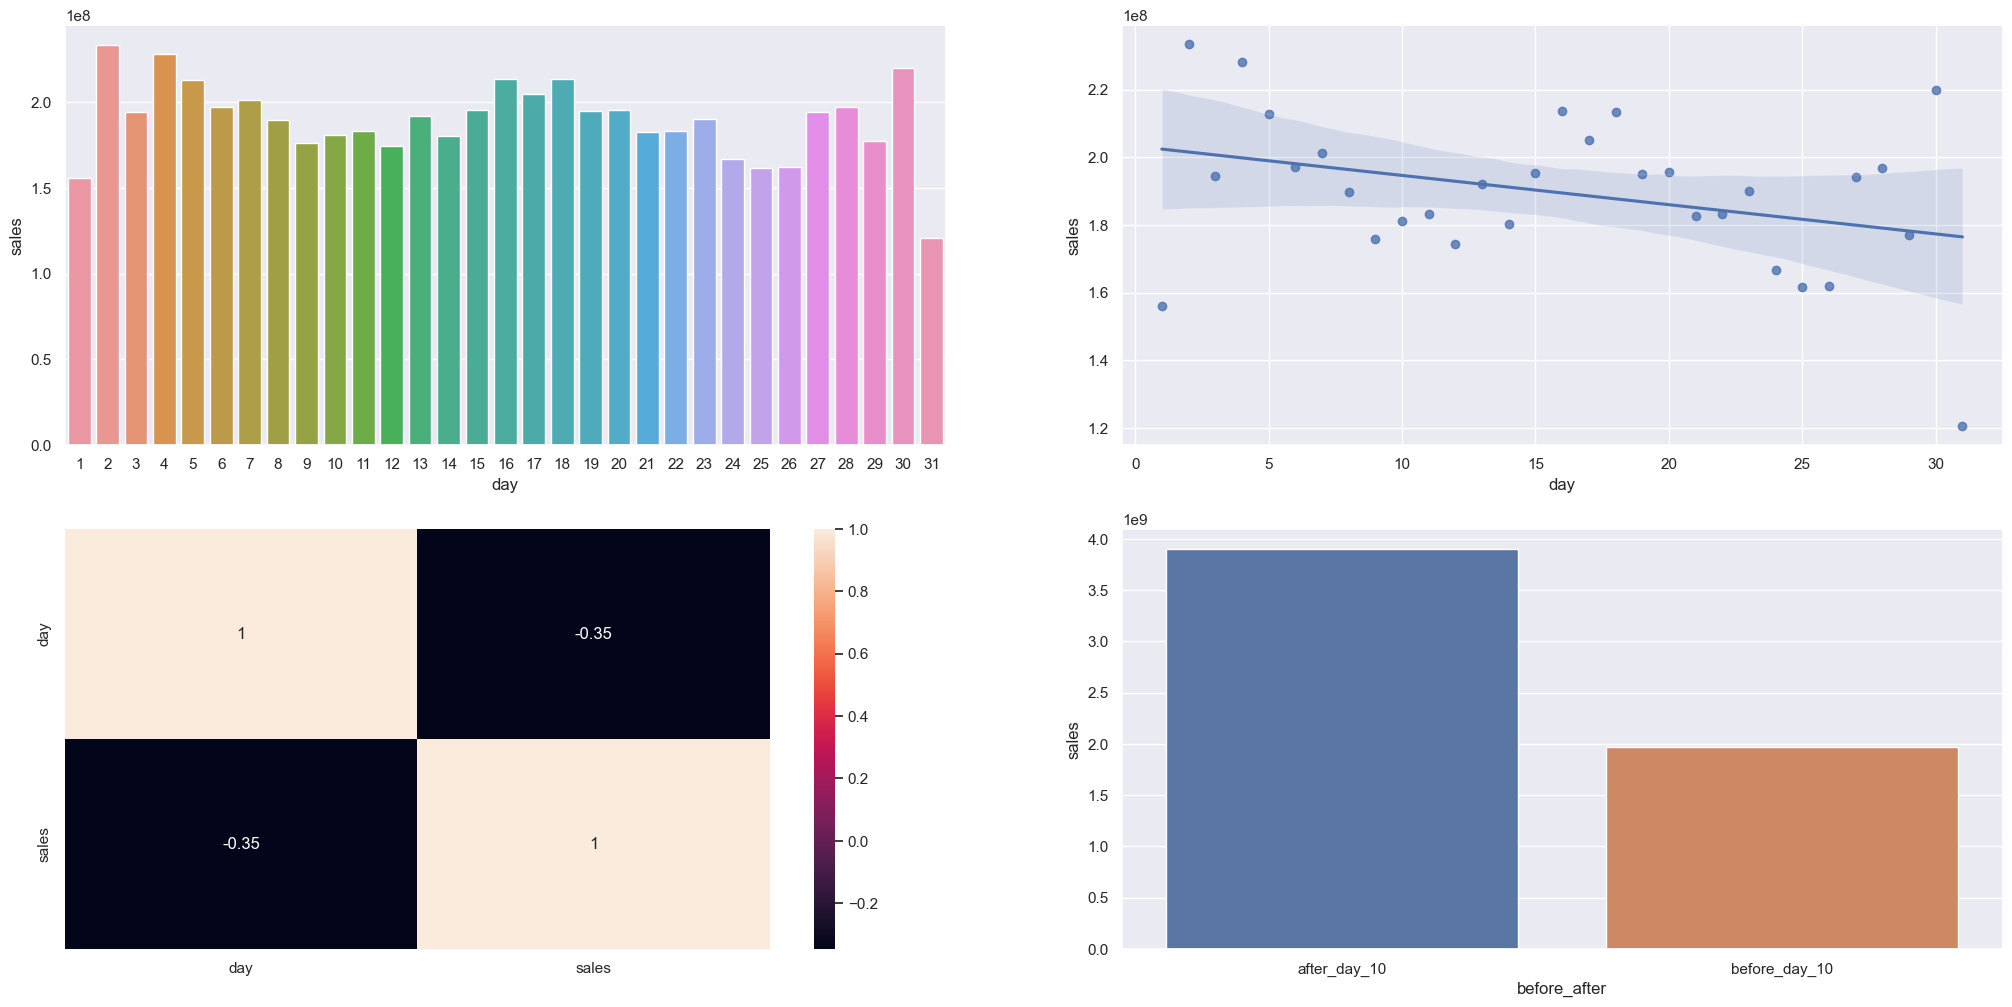

In [45]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson', numeric_only=True ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### 11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**: Lojas vendem menos aos finais de semana.

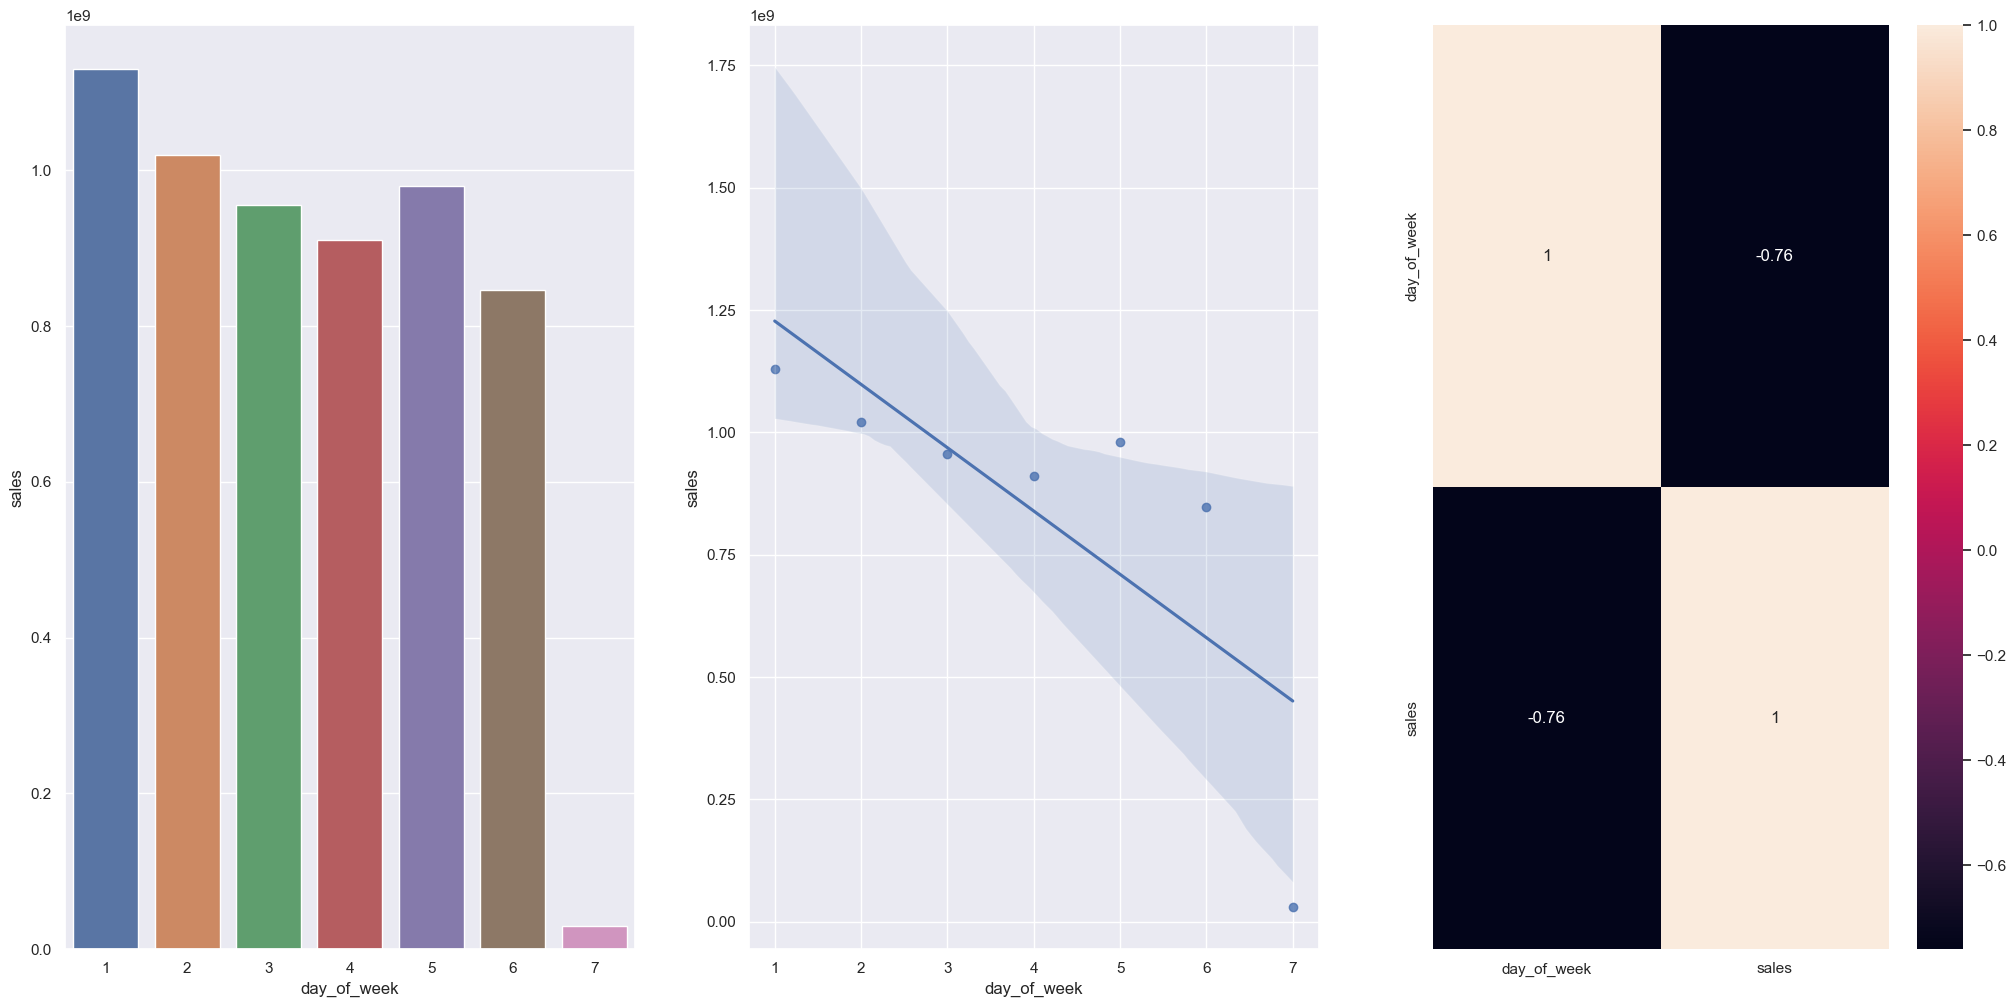

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 12. Lojas deveriam vender menos durante os feriados escolares.
**FALSA**: Em média, lojas vendem MAIS durantes os feriados escolares, exceto no mês de Dezembro.

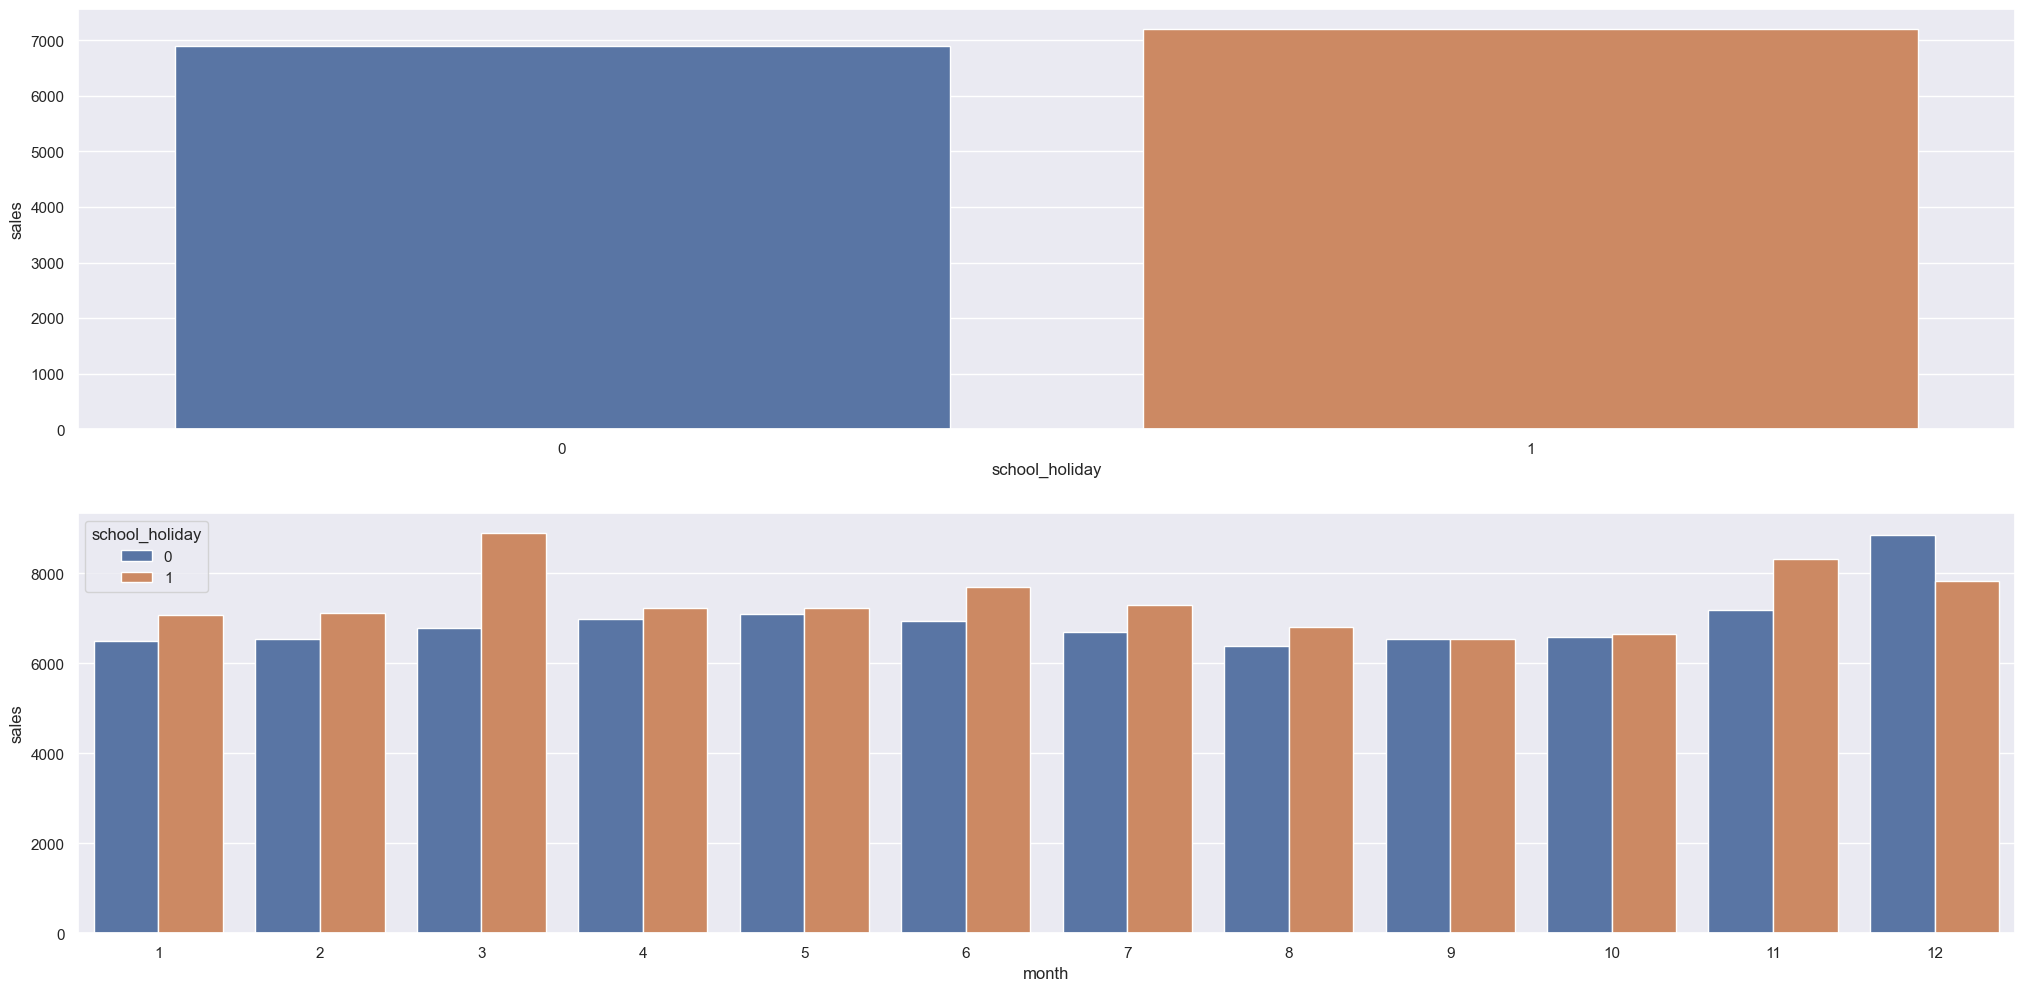

In [47]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1. Resumo das Hipóteses

In [48]:
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Verdadeira', 'Baixa'],  
      ['H2', 'Verdadeira', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Verdadeira', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Falsa', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Verdadeira   Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Verdadeira   Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Falsa        Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

<Axes: >

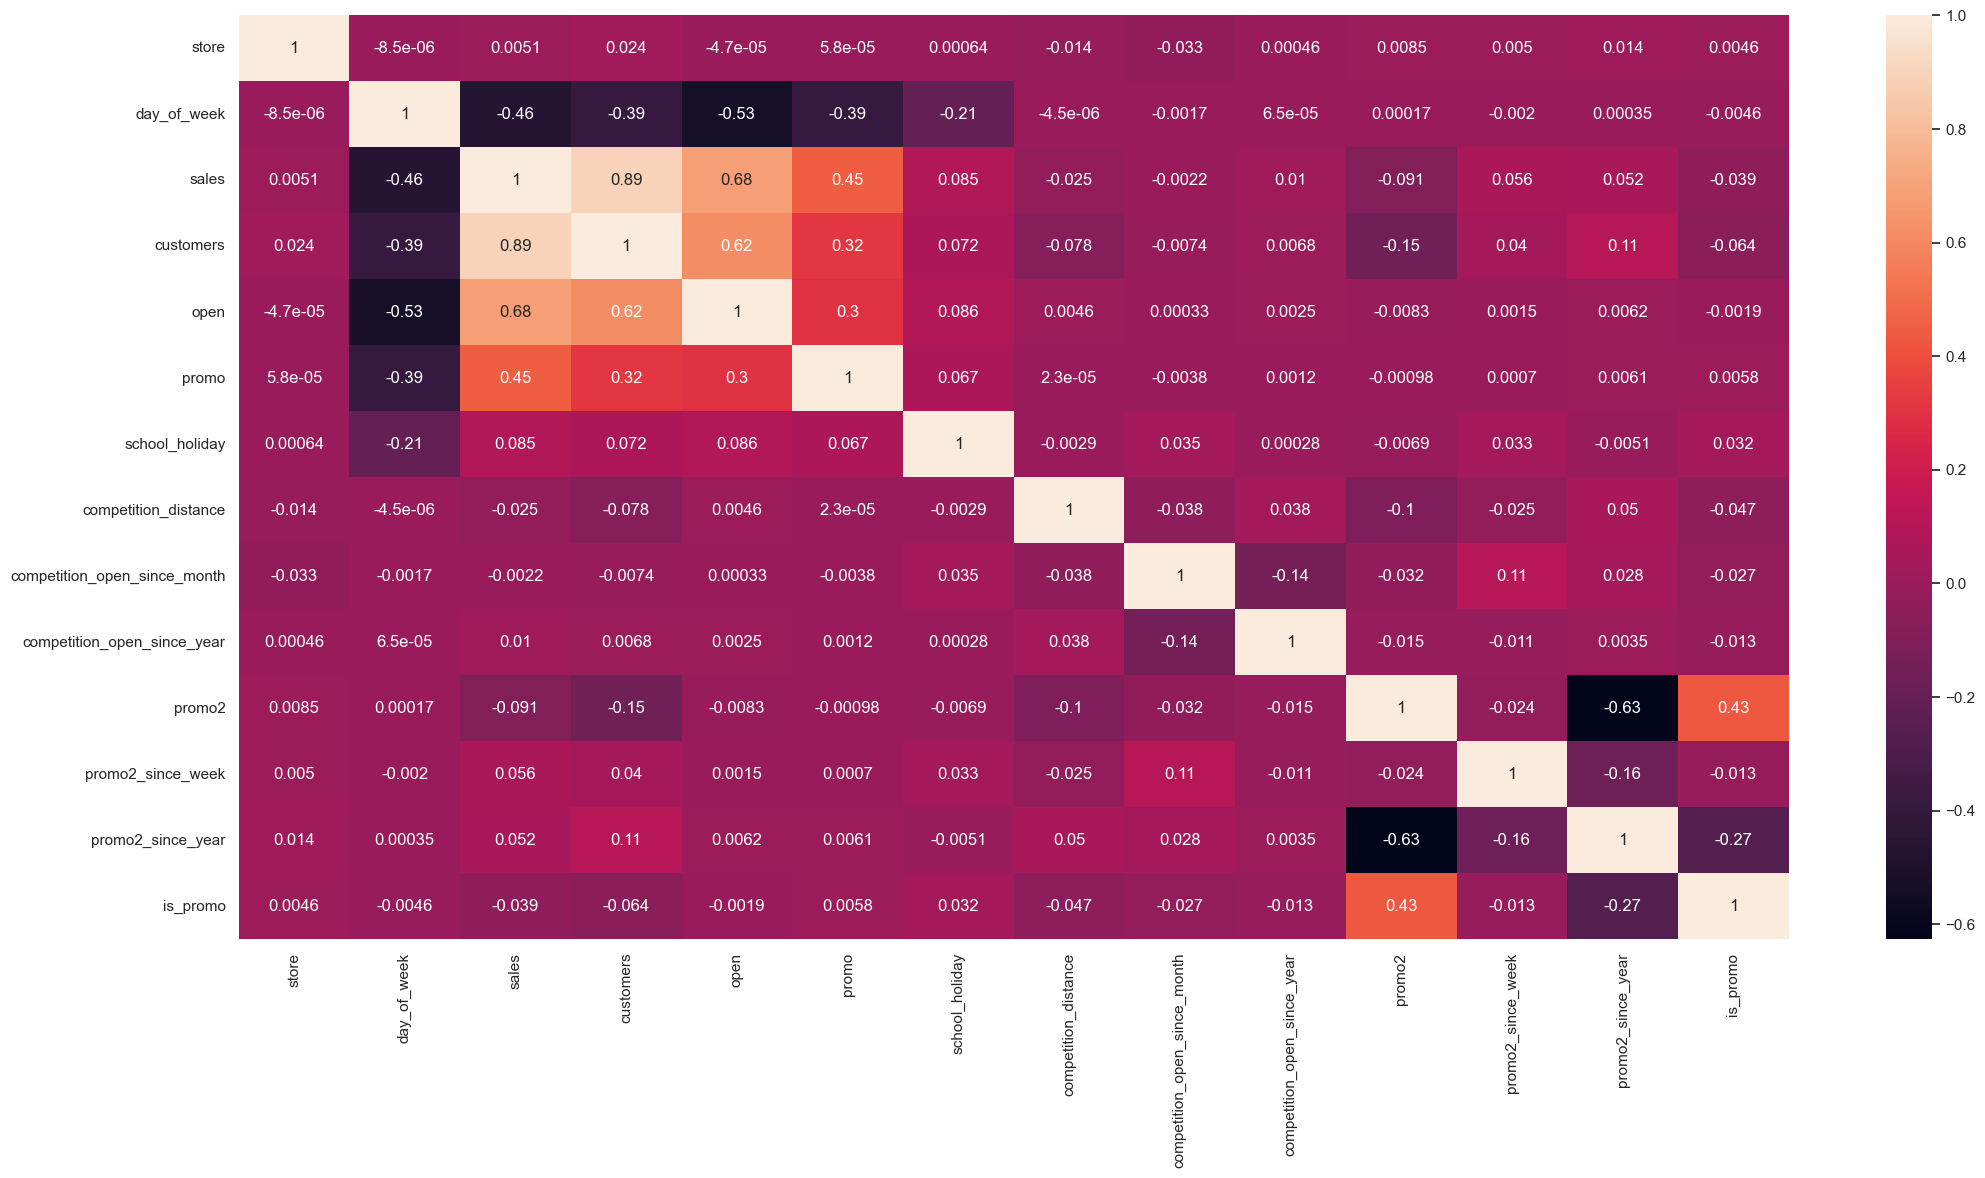

In [49]:
correlation = num_attributes.corr( method = 'pearson')
sns.heatmap( correlation, annot = True )

### 4.3.2. Categorical Attributes

<Axes: >

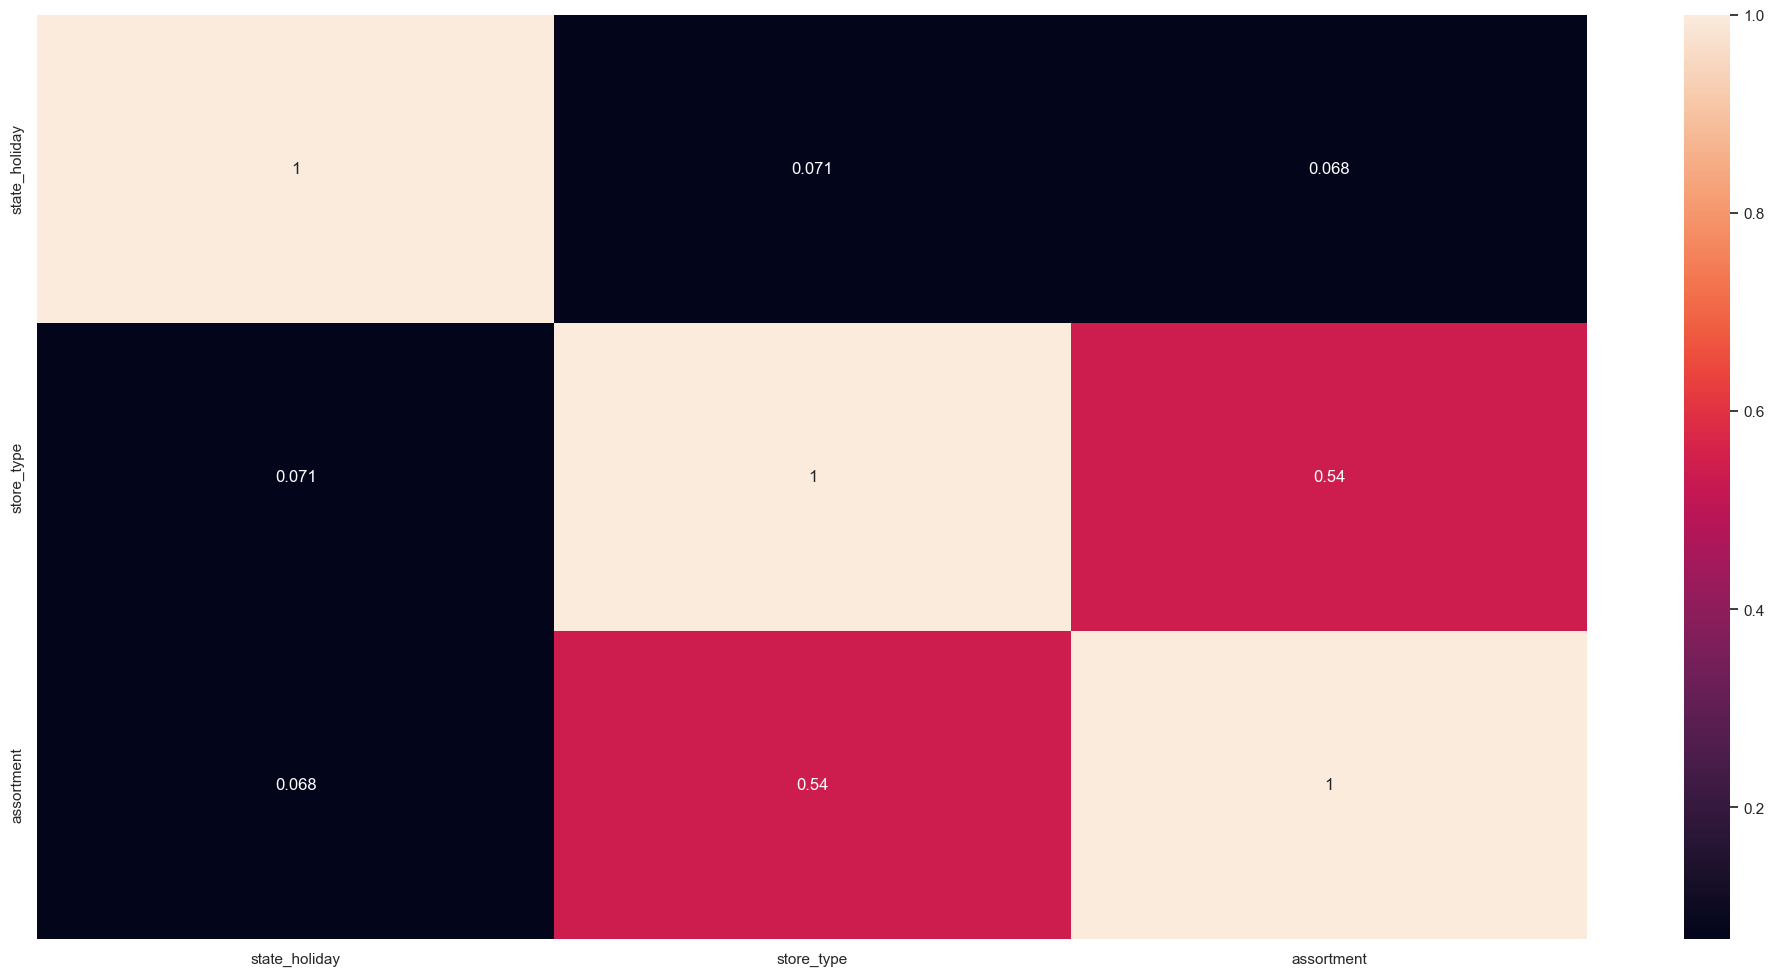

In [50]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# Passo 5. PREPARAÇÃO DOS DADOS

## 5.0 Data Copy

In [51]:
df5 = df4.copy()

In [52]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

## 5.1. Normalização

## 5.2. Rescaling

In [53]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )


## 5.3. Transformação

### 5.3.1. Encoding

In [54]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [55]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [56]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# Passo 06. SELEÇÃO DE FEATURES

## 6.0. Data Copy

In [57]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [58]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [59]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")
print()
print(f"Test Min Date: {X_test['date'].min()}")
print(f"Test Max Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [57]:
# training ad test for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs = 1 )

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit( X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [58]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection 

In [60]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [60]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# Passo 07. MACHINE LEARNING MODELLING

In [61]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [62]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns ={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [63]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [64]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [65]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [66]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [67]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

#performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [68]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5. XGBoost  Regressor

In [69]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.544086,0.949457,7330.812159


### 7.5.1. XGBoost Regressor - Cross Validation

In [70]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


## 7.6. Compare Models' Performance

### 7.6.1. Single Performance

In [71]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.544086,0.949457,7330.812159


### 7.6.2. Real Performance - Cross Validation

In [72]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


# Passo 08. HYPERPARAMETER FINE TUNING 

## 8.1. Random Search

In [73]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [74]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [75]:
#final_result

## 8.2. Final Model

In [67]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [68]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,770.209978,0.115623,1108.062869


In [69]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.01598888634252218

# Passo 09. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

## 9.0 Data Copy

In [70]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\Cweiland\AppData\Local\Temp\ipykernel_8904\2623566156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
C:\Users\Cweiland\AppData\Local\Temp\ipykernel_8904\2623566156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. Business Performance

In [71]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [81]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
759,760,278836.968750,277625.788020,280048.149480,1211.180730,0.146467
307,308,320185.343750,319329.126742,321041.560758,856.217008,0.097869
273,274,188721.640625,187218.143941,190225.137309,1503.496684,0.258065
349,350,261086.343750,260428.952544,261743.734956,657.391206,0.096228


In [72]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107259.992188,103900.995760,110618.988615,3358.996428,0.588526
908,909,218136.984375,210139.046769,226134.921981,7997.937606,0.523377
169,170,210068.781250,208498.057327,211639.505173,1570.723923,0.388486
901,902,202738.703125,201256.792243,204220.614007,1481.910882,0.369999
875,876,196581.156250,192483.555006,200678.757494,4097.601244,0.338941


<Axes: xlabel='store', ylabel='MAPE'>

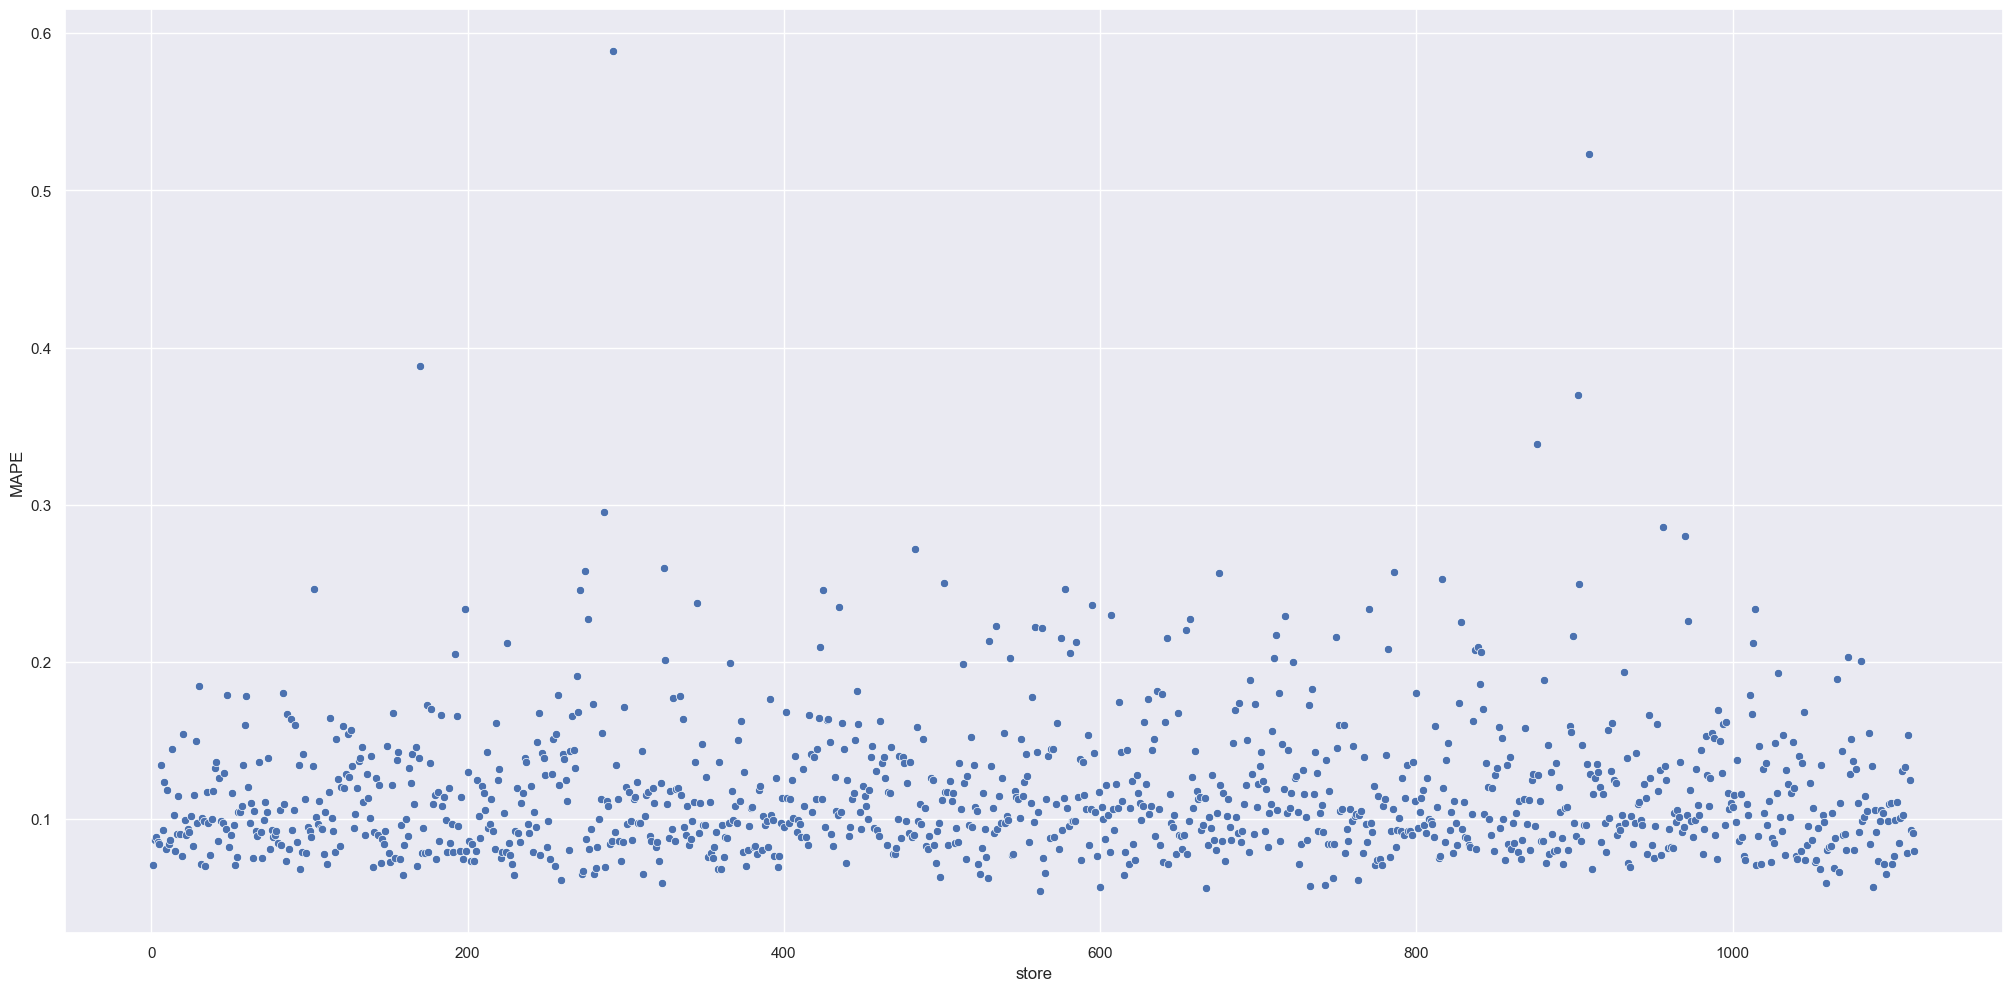

In [83]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [73]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$ 285,817,920.00"
1,worst_scenario,"R$ 284,955,855.73"
2,best_scenario,"R$ 286,679,971.81"


## 9.3. Machine Learning Performance

In [74]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\Cweiland\AppData\Local\Temp\ipykernel_8904\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\Cweiland\AppData\Local\Temp\ipykernel_8904\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


<Axes: xlabel='predictions', ylabel='error'>

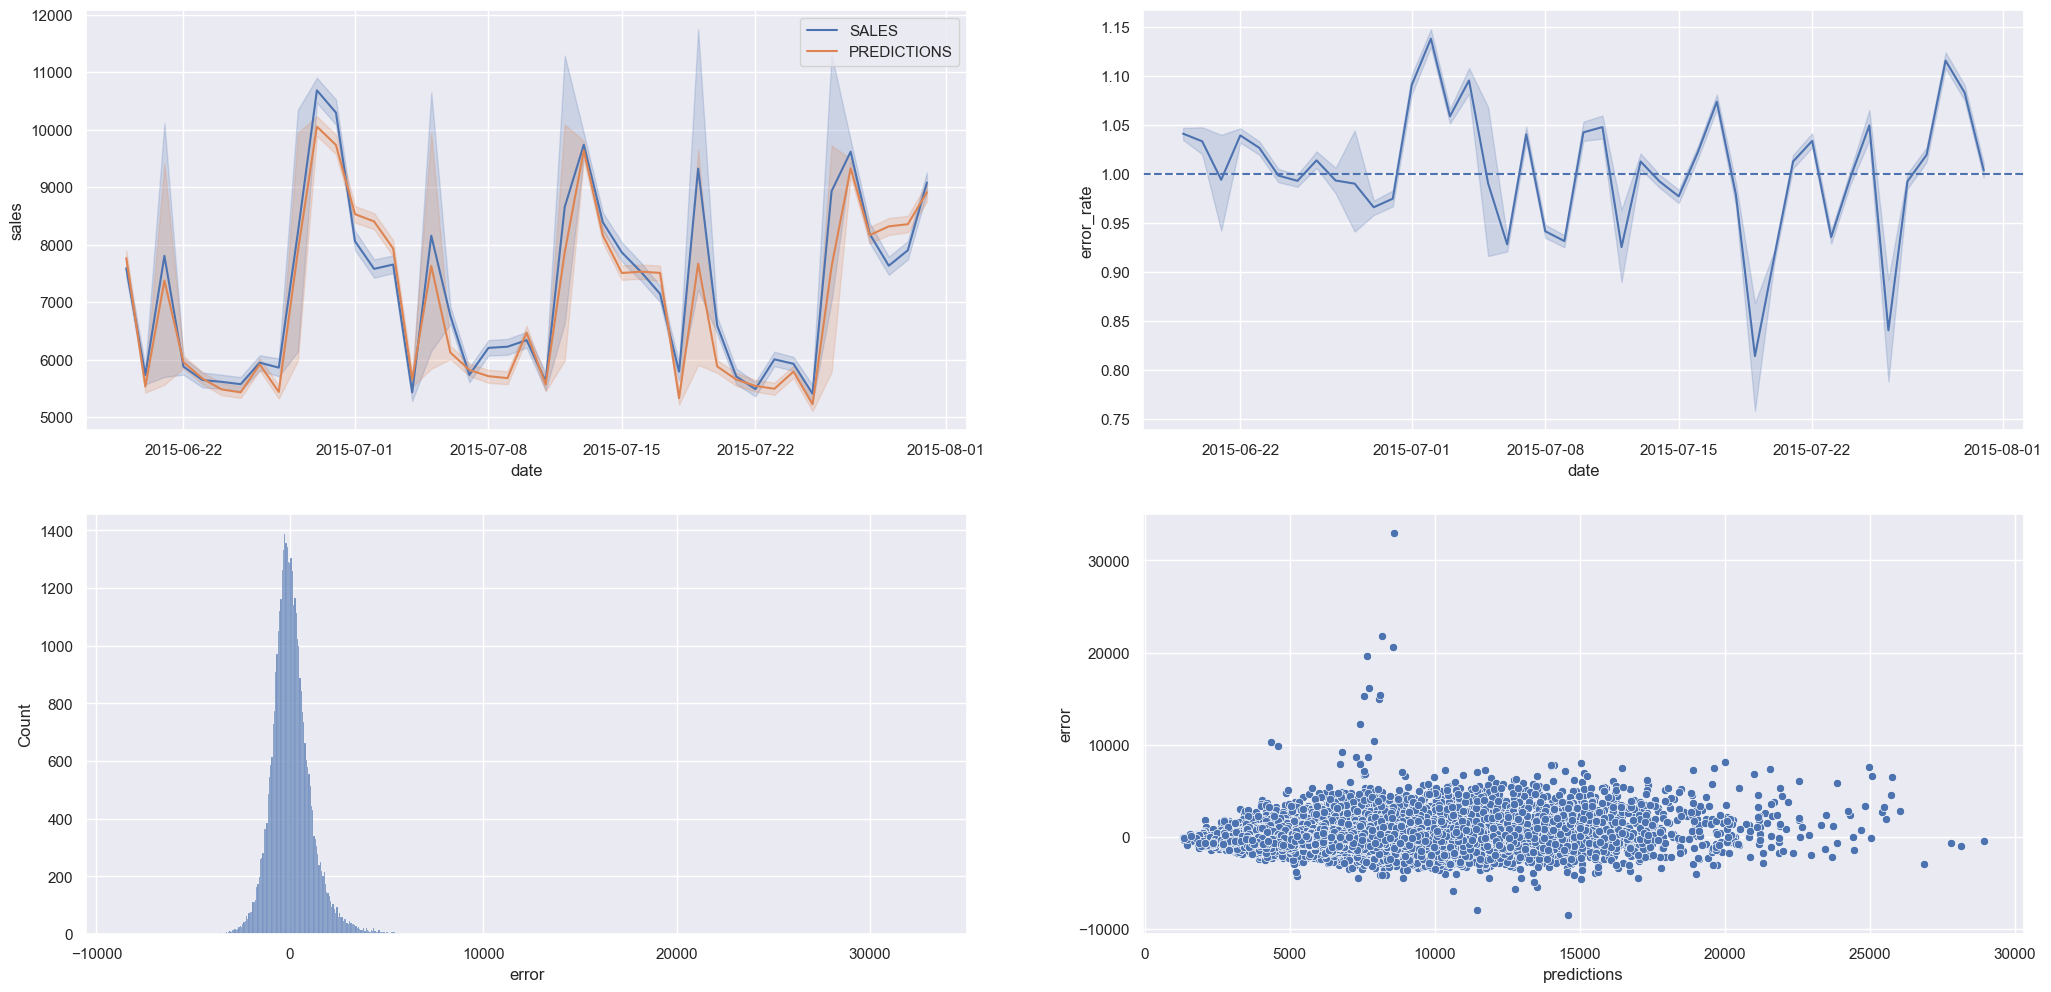

In [76]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.histplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( data=df9, x='predictions', y='error' )

# Passo 10. DEPLOY DO MODELO EM PRODUÇÃO

In [4]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pkl', 'wb' ) )

NameError: name 'model_xgb_tuned' is not defined

## 10.1. Rossmann Class

In [5]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:/Users/Cweiland/repos/ds_l3_data_science_em_producao/'
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df: pd.DataFrame) -> pd.DataFrame:
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df.columns = cols_new

        ## 1.3. Data types
        df['date'] = pd.to_datetime(df['date'])

        ## 1.5. Fillout NA
        # competition_distance
        df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if
        math.isnan(x['competition_open_since_month']) else
        x['competition_open_since_month'], axis=1)
        # competition_open_since_year
        df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if
        math.isnan(x['competition_open_since_year']) else
        x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df['promo2_since_week'] = df.apply(lambda x: x['date'].week if
        math.isnan(x['promo2_since_week']) else
        x['promo2_since_week'], axis=1)

        # promo2_since_year
        df['promo2_since_year'] = df.apply(lambda x: x['date'].year if
        math.isnan(x['promo2_since_year']) else
        x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df['promo_interval'].fillna(0, inplace=True)

        df['month_map'] = df['date'].dt.month.map(month_map)

        df['is_promo'] = df[['promo_interval', 'month_map']].apply(lambda x: 0 if
        x['promo_interval'] == 0 else 1
        if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6. Change Types
        df['competition_open_since_month'] = df['competition_open_since_month'].astype(np.int64)
        df['competition_open_since_year'] = df['competition_open_since_year'].astype(np.int64)

        df['promo2_since_week'] = df['promo2_since_week'].astype(np.int64)
        df['promo2_since_year'] = df['promo2_since_year'].astype(np.int64)

        return df

    def feature_engineering(self, df: pd.DataFrame) -> pd.DataFrame:
        # year
        df['year'] = df['date'].dt.year
        # month
        df['month'] = df['date'].dt.month
        # day
        df['day'] = df['date'].dt.day
        # week of year
        df['week_of_year'] = df['date'].dt.isocalendar().week.astype(np.int64)
        # year week
        df['year_week'] = df['date'].dt.strftime('%Y-%W')

        # competition since
        df['competition_since'] = df.apply(
            lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],
                                        day=1), axis=1)
        df['competition_time_month'] = ((df['date'] - df['competition_since']) / 30).apply(lambda x: x.days).astype(
            int)

        # promo since
        df['promo_since'] = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)
        df['promo_since'] = df['promo_since'].apply(
            lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df['promo_time_week'] = ((df['date'] - df['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assortment
        df['assortment'] = df['assortment'].apply(
            lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df['state_holiday'] = df['state_holiday'].apply(lambda
                                                              x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ## 3.1. Filtragem das Linhas
        df = df[(df['open'] != 0)]

        ## 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df = df.drop(cols_drop, axis=1)

        return df

    def data_preparation(self, df: pd.DataFrame) -> pd.DataFrame:
        ## 5.2. Rescaling
        # competition distance
        df['competition_distance'] = self.competition_distance_scaler.fit_transform(
            df[['competition_distance']].values)

        # competition_time_month
        df['competition_time_month'] = self.competition_time_month_scaler.fit_transform(
            df[['competition_time_month']].values)

        # promo_time_week
        df['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df[['promo_time_week']].values)

        # year
        df['year'] = self.year_scaler.fit_transform(df[['year']].values)

        ## 5.3. Transformação
        ### 5.3.1. Encoding

        # state_holiday - One Hot Encoding
        df = pd.get_dummies(df, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df['store_type'] = self.store_type_scaler.fit_transform(df['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df['assortment'] = df['assortment'].map(assortment_dict)

        ### 5.3.3. Nature Transformation

        # day of week
        df['day_of_week_sin'] = df['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df['day_of_week_cos'] = df['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # month
        df['month_sin'] = df['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df['month_cos'] = df['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # day
        df['day_sin'] = df['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df['day_cos'] = df['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # week of year
        df['week_of_year_sin'] = df['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df['week_of_year_cos'] = df['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year',
                         'competition_time_month', 'promo_time_week',
                         'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                         'week_of_year_sin', 'week_of_year_cos']

        return df[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [6]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:/Users/Cweiland/repos/ds_l3_data_science_em_producao/model/model_rossmann.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df = pipeline.feature_engineering( df )
        
        #data preparation
        df = pipeline.data_preparation( df )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
        

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [5]:
import requests
import json

In [6]:
# loading test dataset
df10 = pd.read_csv( 'C:/Users/Cweiland/repos/ds_l3_data_science_em_producao/data/test.csv')

In [18]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 12, 21] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[-df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )


In [19]:
# convert DataFrame to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [20]:
# API call
url = 'https://rossmann-sales-prediction-api.onrender.com/rossmann/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header)
print( f'Status Code {r.status_code}')

Status Code 200


In [21]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [22]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len (d2 ) ):
    print(f"Loja número {d2.loc[i, 'store']} venderá € {d2.loc[i, 'prediction']:,.2f} nas próximas 6 semanas.")

Loja número 12 venderá € 233,610.67 nas próximas 6 semanas.
Loja número 20 venderá € 267,309.44 nas próximas 6 semanas.
Loja número 21 venderá € 190,571.20 nas próximas 6 semanas.
